In [219]:
import pandas as pd
import numpy as np
import dateutil.easter
import matplotlib.pyplot as plt
from prophet import Prophet
from itertools import product
from prophet.diagnostics import cross_validation, performance_metrics
from IPython.display import display
from typing import Optional, List, Dict, Tuple
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [220]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
df_national = pd.read_csv('../data/processed/data_processed_v3_National_NoAcum_Total.csv')
df_national.head()

,Year,Week,Date,Epi_Year,total_cases
0,2014,2,2014-01-13,2014,4.0
1,2014,3,2014-01-20,2014,29.0
2,2014,4,2014-01-27,2014,47.0
3,2014,5,2014-02-03,2014,36.0
4,2014,6,2014-02-10,2014,42.0


In [221]:
# Prepare dataframe for Prophet
df_national = df_national.rename(columns={'Date': 'ds', 'total_cases': 'y'})
df_national['ds'] = pd.to_datetime(df_national['ds'])
df_national = df_national.sort_values('ds')
print("DataFrame prepared for Prophet - Head:")
print(df_national.head())
print("")
print("DataFrame prepared for Prophet - Tail:")
print(df_national.tail())

DataFrame prepared for Prophet - Head:
   Year  Week         ds  Epi_Year     y
0  2014     2 2014-01-13      2014   4.0
1  2014     3 2014-01-20      2014  29.0
2  2014     4 2014-01-27      2014  47.0
3  2014     5 2014-02-03      2014  36.0
4  2014     6 2014-02-10      2014  42.0

DataFrame prepared for Prophet - Tail:
     Year  Week         ds  Epi_Year     y
568  2024    48 2024-11-25      2024  33.0
569  2024    49 2024-12-02      2024  49.0
570  2024    50 2024-12-09      2024  38.0
571  2024    51 2024-12-16      2024  32.0
572  2024    52 2024-12-23      2024  36.0


In [222]:
df_states_original = pd.read_csv('../data/processed/data_processed_v3_NoAcum_Total.csv')
df_states_sex_original = pd.read_csv('../data/processed/data_processed_v3_NoAcum_MF.csv')
states_list = df_states_original['Entity'].unique().tolist()
try:
    states_list.remove('National')
except ValueError:
    pass

In [223]:
# Prepare dataframes for each state
dfs_states = {}
for state in states_list:
    df_state = df_states_original[df_states_original['Entity'] == state].copy()
    df_state = df_state.groupby('Date')['total_cases'].sum().reset_index()
    df_state = df_state.rename(columns={'Date': 'ds', 'total_cases': 'y'})
    df_state['ds'] = pd.to_datetime(df_state['ds'])
    df_state = df_state.sort_values('ds')
    dfs_states[state] = df_state

print("Prepared DataFrames for each state:")
for i, (state, df) in enumerate(dfs_states.items()):
    print(f"State: {state}")
    print(df.head())
    print("")
    if i == 5: 
        break

Prepared DataFrames for each state:
State: Aguascalientes
          ds    y
0 2014-01-13  0.0
1 2014-01-20  0.0
2 2014-01-27  0.0
3 2014-02-03  0.0
4 2014-02-10  0.0

State: Baja California
          ds    y
0 2014-01-13  0.0
1 2014-01-20  6.0
2 2014-01-27  1.0
3 2014-02-03  3.0
4 2014-02-10  4.0

State: Baja California Sur
          ds    y
0 2014-01-13  0.0
1 2014-01-20  0.0
2 2014-01-27  0.0
3 2014-02-03  0.0
4 2014-02-10  0.0

State: Campeche
          ds    y
0 2014-01-13  0.0
1 2014-01-20  0.0
2 2014-01-27  1.0
3 2014-02-03  1.0
4 2014-02-10  3.0

State: Chiapas
          ds    y
0 2014-01-13  0.0
1 2014-01-20  0.0
2 2014-01-27  1.0
3 2014-02-03  1.0
4 2014-02-10  2.0

State: Chihuahua
          ds    y
0 2014-01-13  0.0
1 2014-01-20  2.0
2 2014-01-27  2.0
3 2014-02-03  2.0
4 2014-02-10  0.0



In [224]:
# Prepare dataframes for each state and sex
dfs_states_sex = {}
for state in states_list:
    for sex in ['M', 'F']: # 'M' = Male, 'F' = Female
        df_ss = df_states_sex_original[df_states_sex_original['Entity'] == state].copy()
        df_ss = df_ss.groupby('Date')[sex].sum().reset_index()
        df_ss = df_ss.rename(columns={'Date': 'ds', sex: 'y'})
        df_ss['ds'] = pd.to_datetime(df_ss['ds'])
        df_ss = df_ss.sort_values('ds')
        dfs_states_sex[(state, sex)] = df_ss
   

print("Prepared DataFrames for each state:")
for i, (state, df) in enumerate(dfs_states_sex.items()):
    print(f"State: {state}")
    print(df.head())
    print("")
    if i == 5:
        break

Prepared DataFrames for each state:
State: ('Aguascalientes', 'M')
          ds    y
0 2014-01-13  0.0
1 2014-01-20  0.0
2 2014-01-27  0.0
3 2014-02-03  0.0
4 2014-02-10  0.0

State: ('Aguascalientes', 'F')
          ds    y
0 2014-01-13  0.0
1 2014-01-20  0.0
2 2014-01-27  0.0
3 2014-02-03  0.0
4 2014-02-10  0.0

State: ('Baja California', 'M')
          ds    y
0 2014-01-13  0.0
1 2014-01-20  1.0
2 2014-01-27  0.0
3 2014-02-03  0.0
4 2014-02-10  1.0

State: ('Baja California', 'F')
          ds    y
0 2014-01-13  0.0
1 2014-01-20  5.0
2 2014-01-27  1.0
3 2014-02-03  3.0
4 2014-02-10  3.0

State: ('Baja California Sur', 'M')
          ds    y
0 2014-01-13  0.0
1 2014-01-20  0.0
2 2014-01-27  0.0
3 2014-02-03  0.0
4 2014-02-10  0.0

State: ('Baja California Sur', 'F')
          ds    y
0 2014-01-13  0.0
1 2014-01-20  0.0
2 2014-01-27  0.0
3 2014-02-03  0.0
4 2014-02-10  0.0



In [225]:
# Holidays definition
years = range(2014, 2030) 
holidays_list = []
for year in years:
    holidays_list.append({'ds': f'{year}-12-25', 'holiday': 'Navidad'})
    holidays_list.append({'ds': f'{year}-01-01', 'holiday': 'Ano_Nuevo'})
    easter_date = dateutil.easter.easter(year)
    holidays_list.append({'ds': easter_date.strftime('%Y-%m-%d'), 'holiday': 'Semana_Santa'})
    friday_before_easter = easter_date - pd.Timedelta(days=2)
    holidays_list.append({'ds': friday_before_easter.strftime('%Y-%m-%d'), 'holiday': 'Viernes_Santo'})

# create dataframe once and set Semana_Santa window
holidays = pd.DataFrame(holidays_list)
holidays.loc[holidays['holiday'] == 'Semana_Santa', 'lower_window'] = -3
holidays.loc[holidays['holiday'] == 'Semana_Santa', 'upper_window'] = 3

In [226]:
def build_mex_holidays(start_year, end_year, add_windows=True):
    rows = []
    for y in range(start_year, end_year + 1):
        rows.append({"ds": pd.Timestamp(f"{y}-12-25"), "holiday": "Navidad"})
        rows.append({"ds": pd.Timestamp(f"{y}-01-01"), "holiday": "Ano_Nuevo"})
        easter= pd.Timestamp(dateutil.easter.easter(y))
        rows.append({"ds": easter, "holiday": "Semana_Santa"})
    hol = pd.DataFrame(rows)
    if add_windows:
        mask = hol['holiday'] == 'Semana_Santa'
        hol.loc[mask, 'lower_window'] = -3
        hol.loc[mask, 'upper_window'] = 3
    return hol


In [227]:
def add_covid_dummy(df, start_covid='2020-03-01', end_covid='2022-12-31 '):
    s = pd.Timestamp(start_covid)
    e = pd.Timestamp(end_covid)
    out = df.copy()
    out['covid_dummy'] = ((out['ds'] >= s) & (out['ds'] <= e)).astype(int)
    return out

In [228]:
# Covid-19 Indicator
start_covid = pd.Timestamp('2020-03-01')
end_covid = pd.Timestamp('2022-12-31') 
def covid_indicator(date):
    if start_covid <= date <= end_covid:
        return 1
    else:
        return 0


df_national['covid_dummy'] = df_national['ds'].apply(covid_indicator)
for state, df_state in dfs_states.items():
    df_state['covid_dummy'] = df_state['ds'].apply(covid_indicator)
for key, df_ss in dfs_states_sex.items():
    df_ss['covid_dummy'] = df_ss['ds'].apply(covid_indicator)

print("DataFrames with Covid-19 indicator added:")
print("National DataFrame - Head:")
print(df_national.head())
print("")
print("State DataFrame Example - Head:")
example_state = list(dfs_states.keys())[0]
print(f"State: {example_state}")
print(dfs_states[example_state].head())
print("")
print("State and Sex DataFrame Example - Head:")
example_key = list(dfs_states_sex.keys())[0]
print(f"State and Sex   : {example_key}")
print(dfs_states_sex[example_key].head())


DataFrames with Covid-19 indicator added:
National DataFrame - Head:
   Year  Week         ds  Epi_Year     y  covid_dummy
0  2014     2 2014-01-13      2014   4.0            0
1  2014     3 2014-01-20      2014  29.0            0
2  2014     4 2014-01-27      2014  47.0            0
3  2014     5 2014-02-03      2014  36.0            0
4  2014     6 2014-02-10      2014  42.0            0

State DataFrame Example - Head:
State: Aguascalientes
          ds    y  covid_dummy
0 2014-01-13  0.0            0
1 2014-01-20  0.0            0
2 2014-01-27  0.0            0
3 2014-02-03  0.0            0
4 2014-02-10  0.0            0

State and Sex DataFrame Example - Head:
State and Sex   : ('Aguascalientes', 'M')
          ds    y  covid_dummy
0 2014-01-13  0.0            0
1 2014-01-20  0.0            0
2 2014-01-27  0.0            0
3 2014-02-03  0.0            0
4 2014-02-10  0.0            0


In [229]:
# Helper to build a Prophet model with our common settings and a parameter dict
def _build_prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, seasonality_mode='multiplicative', changepoint_prior_scale=0.1, seasonality_prior_scale=5.0, holidays_prior_scale=0.5, changepoint_range=0.8, holidays: Optional[pd.DataFrame] = None, add_regressors: Optional[List[str]] = None):
    m = Prophet(yearly_seasonality=yearly_seasonality, weekly_seasonality=weekly_seasonality, daily_seasonality=daily_seasonality, seasonality_mode=seasonality_mode,
                changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale, holidays_prior_scale=holidays_prior_scale, changepoint_range=changepoint_range, holidays=holidays)
    if add_regressors:
        for reg in add_regressors:
            m.add_regressor(reg)
    return m

In [230]:
def _prophet_cv_smape(model, df, horizon_weeks=52, initial_years=3, period_weeks=26):
    # horizon_weeks: number of weeks to forecast in each fold
    # initial_years: number of years for the initial training period
    # period_weeks: spacing between cutoff dates
    
    horizon = f"{7*horizon_weeks} days"
    initial = f"{365*initial_years} days"
    period = f"{7*period_weeks} days"

    cv_df = cross_validation(model, horizon=horizon, initial=initial, period=period, parallel="processes")
    perf = performance_metrics(cv_df, rolling_window=1)

    return perf['smape'].mean()

In [231]:
def tune_prophet_for_df(df, holidays, add_reggresors: Optional[List[str]] = None, param_grid: Optional[Dict[str, List]] = None, random_k: Optional[int] = None, horizon_weeks=52, intial_years=3, period_weeks=26, verbose=True):
    if param_grid is None:
        param_grid = {
            "seasonality_mode": ["multiplicative", "additive"],
            "changepoint_prior_scale": [0.01, 0.1, 0.5],
            "seasonality_prior_scale": [1.0, 5.0, 10.0],
            "holidays_prior_scale": [1.0, 5.0, 10.0],
            "changepoint_range": [0.7, 0.8, 0.9],
        }
    keys, values = zip(*param_grid.items())
    all_param_combinations = [dict(zip(keys, v)) for v in product(*values)]
    if random_k is not None and random_k < len(all_param_combinations):
        np.random.shuffle(all_param_combinations)
        combos = all_param_combinations[:random_k]
    else:
        combos = all_param_combinations
    
    best_params, best_model, best_smape = None, None, float('inf')

    for i, p in enumerate(combos, start=1):
        try:
            if verbose:
                print(f"[tuning] combination {i}/{len(combos)} -> {p}")
            model = _build_prophet(
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False,
                seasonality_mode=p['seasonality_mode'],
                changepoint_prior_scale=p['changepoint_prior_scale'],
                seasonality_prior_scale=p['seasonality_prior_scale'],
                holidays_prior_scale=p['holidays_prior_scale'],
                changepoint_range=p['changepoint_range'],
                holidays=holidays,
                add_regressors=add_reggresors
            )
            model.fit(df)

            smape = _prophet_cv_smape(
                model, df, horizon_weeks=horizon_weeks, initial_years=intial_years, period_weeks=period_weeks
            )

            if verbose:
                print(f"    -> SMAPE: {smape:.4f}")
            if smape < best_smape:
                best_smape = smape
                best_params = p
                best_model = model
        except Exception as e:
            if verbose:
                print(f"    !!! Exception during tuning: {e}")
            continue

    
    if best_model is None:
        raise RuntimeError("No valid model found during tuning.")
    
    if verbose:
        print("\nBest hyperparameters found:", best_params)
        print(f"With SMAPE: {best_smape:.4f}")
    return best_params, best_model, best_smape

In [232]:
def fit_and_forecast(df,params,holidays,add_regressors: Optional[List[str]],horizon_weeks=260,freq="W-MON"):
    m = _build_prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode=params.get("seasonality_mode", "multiplicative"),
        changepoint_prior_scale=params.get("changepoint_prior_scale", 0.1),
        seasonality_prior_scale=params.get("seasonality_prior_scale", 5.0),
        holidays_prior_scale=params.get("holidays_prior_scale", 5.0),
        changepoint_range=params.get("changepoint_range", 0.8),
        holidays=holidays,
        add_regressors=add_regressors
    )
    m.fit(df)
    future = m.make_future_dataframe(periods=horizon_weeks, freq=freq)
    # Extend regressors into the future
    for reg in (add_regressors or []):
        if reg == "covid_dummy":
            # por diseño la pandemia no continúa → 0 en el futuro
            tmp = add_covid_dummy(future[["ds"]])
            future["covid_dummy"] = tmp["covid_dummy"].values
        else:
            raise ValueError(f"Extend regressor into the future for: {reg}")
    forecast = m.predict(future)
    return m, forecast

In [233]:
def clean_outliers_hampel(df, y_col, window, n_sigmas, replacement):
    df = df.sort_values("ds").copy()
    s = df[y_col].astype(float)

    med = s.rolling(window, center=True, min_periods = 1).median()
    mad = (np.abs(s - med)).rolling(window,center=True, min_periods=1).median()
    k = 1.4826 
    thr = n_sigmas * k * (mad + 1e-12)
    mask = (np.abs(s - med) > thr)

    df["y_original"] = s
    df["outlier_flag"] = mask.astype(int)

    if replacement == "nan":
        df.loc[mask, y_col] = np.nan
    elif replacement == "median":
        df.loc[mask, y_col] = med[mask]
    else:
        raise ValueError("Replacement method must be meadian or nan")

    return df

In [234]:
def hierarchical_tuning_and_forecast(df_national, dfs_states, dfs_states_sex, start_year=None, end_year=None, covid_start="2020-03-01", covid_end="2022-12-31", horizon_weeks_cv=52, initial_years_cv=3, period_weeks_cv=26, horizon_weeks_forecast=260, grid_national: Optional[Dict[str, List]] = None, random_k_state = 8, micro_tune_sex=False, clean_outliers = True, outlier_window = 9, outlier_k = 3.0, outlier_replacement = "nan", verbose=True):
    # Holidays for the whole range
    if start_year is None:
        start_year = pd.to_datetime(df_national["ds"]).min().year
    if end_year is None:
        end_year = pd.to_datetime(df_national["ds"]).min().year + 5
    
    holidays = build_mex_holidays(start_year, end_year, add_windows=True)

    df_national = add_covid_dummy(df_national, covid_start, covid_end)
    dfs_states = {s: add_covid_dummy(df, covid_start, covid_end) for s, df in dfs_states.items()}
    dfs_states_sex = {(s, sex) : add_covid_dummy(df, covid_start, covid_end) for (s, sex), df in dfs_states_sex.items()}

    add_regs = ["covid_dummy"]

    # Clean outliers if requested
    if clean_outliers:
        if verbose:
            print("Cleaning outliers (Hampel) in the entire hierarchy")
        
        df_national = clean_outliers_hampel(df_national, y_col="y", window=outlier_window,n_sigmas=outlier_k, replacement=outlier_replacement)
        dfs_states = {s: clean_outliers_hampel(df, y_col="y", window=outlier_window,n_sigmas=outlier_k, replacement=outlier_replacement)for s, df in dfs_states.items()}
        dfs_states_sex = {(s, sex): clean_outliers_hampel(df, y_col="y", window=outlier_window, n_sigmas=outlier_k, replacement=outlier_replacement) for (s, sex), df in dfs_states_sex.items()}


    # National Level

    if verbose:
        print("National Level Tunning")
    best_params_nat, best_model_nat, best_smape_nat = tune_prophet_for_df(df_national, holidays, add_regs, grid_national, None, horizon_weeks_cv, initial_years_cv, period_weeks_cv, verbose)
    if verbose:
        print("National BEST:", best_params_nat, "sMAPE:", round(best_smape_nat, 3))
    if verbose:
        print("National Level Forecast")
    model_nat, forecast_nat = fit_and_forecast(df_national, best_params_nat, holidays, add_regs, horizon_weeks_forecast)

    # State Level
    if verbose:
        print("State Level Tunning")
    params_states = {}
    forecasts_states = {}
    for state, df_s in dfs_states.items():
        p_state, _, sm = tune_prophet_for_df(df_s, holidays, add_regs, None, random_k_state, horizon_weeks_cv, initial_years_cv, period_weeks_cv, False)
        params_states[state] = p_state
        if verbose:
            print(f"[{state}] sMAPE={sm:.2f} params={p_state}")
        
        # Forecast with choose params
        _, f_s = fit_and_forecast(df_s, params_states[state], holidays, add_regs, horizon_weeks_forecast)
        forecasts_states[state] = f_s
    
    # State - Sex Level
    if verbose: 
        print("State - Sex Level Tunning")
    params_states_sex: Dict[Tuple[str,str], Dict] = {}
    forecasts_states_sex: Dict[Tuple[str,str], pd.DataFrame] = {}

    for (state, sex), df_ss in dfs_states_sex.items():
        base_params = params_states.get(state, best_params_nat).copy()
        chosen_params = base_params

        # Micro-tuning 
        if micro_tune_sex and len(df_ss) >= 52*(initial_years_cv+1):
            tiny_grid = {
                "seasonality_mode": [base_params.get("seasonality_mode", "multiplicative")],
                "changepoint_prior_scale": [base_params["changepoint_prior_scale"]*f
                                            for f in [0.5, 1.0, 2.0]],
                "seasonality_prior_scale": [base_params["seasonality_prior_scale"]],
                "holidays_prior_scale": [base_params["holidays_prior_scale"]],
                "changepoint_range": [base_params.get("changepoint_range", 0.8)]
            }
            try:
                p_ss, _, sm_ss = tune_prophet_for_df(df_ss, holidays, add_regs, tiny_grid, None, horizon_weeks_cv, initial_years_cv, period_weeks_cv,False)
                chosen_params = p_ss
                if verbose:
                    print(f"[{state}-{sex}] micro-tune sMAPE≈{sm_ss:.2f} params={p_ss}")
            except Exception as e:
                if verbose:
                    print(f"[{state}-{sex}] micro-tune failed ({e}). Use params from state")

        params_states_sex[(state, sex)] = chosen_params
        _, f_ss = fit_and_forecast(df_ss, chosen_params, holidays,add_regs, horizon_weeks_forecast)
        forecasts_states_sex[(state, sex)] = f_ss

    return {
        "national": {
            "params": best_params_nat, "forecast": forecast_nat
        },
        "states": {
            "params": params_states, "forecasts": forecasts_states
        },
        "states_sex": {
            "params": params_states_sex, "forecasts": forecasts_states_sex
        },
        "holidays": holidays
    }

    

In [235]:
national_grid_opt = {
    "seasonality_mode": ["multiplicative", "additive"],
    "changepoint_prior_scale": [0.05, 0.1, 0.2],
    "seasonality_prior_scale": [1.0, 5.0, 10.0],
    "holidays_prior_scale": [1.0, 5.0],
    "changepoint_range": [0.8, 0.95],
}

res = hierarchical_tures = hierarchical_tuning_and_forecast(
    df_national=df_national,
    dfs_states=dfs_states,
    dfs_states_sex=dfs_states_sex,
    grid_national=national_grid_opt,
    random_k_state=8,      
    micro_tune_sex=False,   
    horizon_weeks_cv=52,
    initial_years_cv=3,
    period_weeks_cv=26,
    horizon_weeks_forecast=260,
    clean_outliers=True,
    outlier_window=9,        
    outlier_k=3.0,           
    outlier_replacement="median",
    verbose=True
)

forecast_nat = res["national"]["forecast"]         
forecasts_states = res["states"]["forecasts"]         
forecasts_states_sex = res["states_sex"]["forecasts"] 

Cleaning outliers (Hampel) in the entire hierarchy


18:41:15 - cmdstanpy - INFO - Chain [1] start processing


National Level Tunning
[tuning] combination 1/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:41:15 - cmdstanpy - INFO - Chain [1] done processing
18:41:17 - cmdstanpy - INFO - Chain [1] start processing
18:41:17 - cmdstanpy - INFO - Chain [1] start processing
18:41:17 - cmdstanpy - INFO - Chain [1] start processing
18:41:17 - cmdstanpy - INFO - Chain [1] start processing
18:41:17 - cmdstanpy - INFO - Chain [1] start processing
18:41:17 - cmdstanpy - INFO - Chain [1] start processing
18:41:17 - cmdstanpy - INFO - Chain [1] start processing
18:41:17 - cmdstanpy - INFO - Chain [1] start processing
18:41:17 - cmdstanpy - INFO - Chain [1] done processing
18:41:17 - cmdstanpy - INFO - Chain [1] done processing
18:41:17 - cmdstanpy - INFO - Chain [1] done processing
18:41:17 - cmdstanpy - INFO - Chain [1] done processing
18:41:17 - cmdstanpy - INFO - Chain [1] done processing
18:41:17 - cmdstanpy - INFO - Chain [1] done processing
18:41:17 - cmdstanpy - INFO - Chain [1] done processing
18:41:17 - cmdstanpy - INFO - Chain [1] done processing
18:41:17 - cmdstanpy - INFO - Chain [1] 

    -> SMAPE: 0.3662
[tuning] combination 2/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing
18:41:20 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3652
[tuning] combination 3/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:41:21 - cmdstanpy - INFO - Chain [1] done processing
18:41:23 - cmdstanpy - INFO - Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing
18:41:23 - cmdstanpy - INFO - Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing
18:41:23 - cmdstanpy - INFO - Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing
18:41:23 - cmdstanpy - INFO - Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing
18:41:23 - cmdstanpy - INFO - Chain [1] 

    -> SMAPE: 0.3650
[tuning] combination 4/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:41:24 - cmdstanpy - INFO - Chain [1] done processing
18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] done processing
18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] done processing
18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] done processing
18:41:26 - cmdstanpy - INFO - Chain [1] done processing
18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] done processing
18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing
18:41:27 - cmdstanpy - INFO - Chain [1] 

    -> SMAPE: 0.3659
[tuning] combination 5/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:41:29 - cmdstanpy - INFO - Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] done processing
18:41:29 - cmdstanpy - INFO - Chain [1] done processing
18:41:29 - cmdstanpy - INFO - Chain [1] done processing
18:41:29 - cmdstanpy - INFO - Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] done processing
18:41:29 - cmdstanpy - INFO - Chain [1] done processing
18:41:29 - cmdstanpy - INFO - Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] done processing
18:41:29 - cmdstanpy - INFO - Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] done processing
18:41:29 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3649
[tuning] combination 6/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:41:32 - cmdstanpy - INFO - Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1] done processing
18:41:32 - cmdstanpy - INFO - Chain [1] done processing
18:41:32 - cmdstanpy - INFO - Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1] done processing
18:41:32 - cmdstanpy - INFO - Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1] done processing
18:41:32 - cmdstanpy - INFO - Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1] done processing
18:41:32 - cmdstanpy - INFO - Chain [1] done processing
18:41:32 - cmdstanpy - INFO - Chain [1] done processing
18:41:32 - cmdstanpy - INFO - Chain [1] done processing
18:41:32 - cmdstanpy - INFO - Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3650
[tuning] combination 7/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:41:33 - cmdstanpy - INFO - Chain [1] start processing
18:41:34 - cmdstanpy - INFO - Chain [1] done processing
18:41:34 - cmdstanpy - INFO - Chain [1] done processing
18:41:36 - cmdstanpy - INFO - Chain [1] start processing
18:41:36 - cmdstanpy - INFO - Chain [1] done processing
18:41:36 - cmdstanpy - INFO - Chain [1] start processing
18:41:36 - cmdstanpy - INFO - Chain [1] done processing
18:41:36 - cmdstanpy - INFO - Chain [1] start processing
18:41:37 - cmdstanpy - INFO - Chain [1] start processing
18:41:37 - cmdstanpy - INFO - Chain [1] done processing
18:41:37 - cmdstanpy - INFO - Chain [1] start processing
18:41:37 - cmdstanpy - INFO - Chain [1] start processing
18:41:37 - cmdstanpy - INFO - Chain [1] done processing
18:41:37 - cmdstanpy - INFO - Chain [1] start processing
18:41:36 - cmdstanpy - INFO - Chain [1] start processing
18:41:36 - cmdstanpy - INFO - Chain [1] done processing
18:41:36 - cmdstanpy - INFO - Chain [1] start processing
18:41:36 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3654
[tuning] combination 8/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:41:39 - cmdstanpy - INFO - Chain [1] start processing
18:41:39 - cmdstanpy - INFO - Chain [1] start processing
18:41:39 - cmdstanpy - INFO - Chain [1] done processing
18:41:39 - cmdstanpy - INFO - Chain [1] done processing
18:41:39 - cmdstanpy - INFO - Chain [1] start processing
18:41:39 - cmdstanpy - INFO - Chain [1] start processing
18:41:40 - cmdstanpy - INFO - Chain [1] start processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing
18:41:40 - cmdstanpy - INFO - Chain [1] start processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing
18:41:40 - cmdstanpy - INFO - Chain [1] start processing
18:41:40 - cmdstanpy - INFO - Chain [1] start processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing
18:41:40 - cmdstanpy - INFO - Chain [1] start processing
18:41:40 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3664
[tuning] combination 9/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:41:40 - cmdstanpy - INFO - Chain [1] start processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing
18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing
18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing
18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing
18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing
18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing
18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3652
[tuning] combination 10/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:41:43 - cmdstanpy - INFO - Chain [1] start processing
18:41:43 - cmdstanpy - INFO - Chain [1] done processing
18:41:43 - cmdstanpy - INFO - Chain [1] done processing
18:41:45 - cmdstanpy - INFO - Chain [1] start processing
18:41:45 - cmdstanpy - INFO - Chain [1] start processing
18:41:45 - cmdstanpy - INFO - Chain [1] start processing
18:41:45 - cmdstanpy - INFO - Chain [1] done processing
18:41:45 - cmdstanpy - INFO - Chain [1] done processing
18:41:45 - cmdstanpy - INFO - Chain [1] start processing
18:41:45 - cmdstanpy - INFO - Chain [1] done processing
18:41:45 - cmdstanpy - INFO - Chain [1] start processing
18:41:45 - cmdstanpy - INFO - Chain [1] start processing
18:41:45 - cmdstanpy - INFO - Chain [1] done processing
18:41:45 - cmdstanpy - INFO - Chain [1] done processing
18:41:45 - cmdstanpy - INFO - Chain [1] done processing
18:41:45 - cmdstanpy - INFO - Chain [1] start processing
18:41:45 - cmdstanpy - INFO - Chain [1] start processing
18:41:45 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3650
[tuning] combination 11/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:41:46 - cmdstanpy - INFO - Chain [1] done processing
18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing
18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing
18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing
18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing
18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing
18:41:48 - cmdstanpy - INFO - Chain [1] 

    -> SMAPE: 0.3654
[tuning] combination 12/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:41:51 - cmdstanpy - INFO - Chain [1] start processing
18:41:51 - cmdstanpy - INFO - Chain [1] start processing
18:41:51 - cmdstanpy - INFO - Chain [1] start processing
18:41:51 - cmdstanpy - INFO - Chain [1] done processing
18:41:51 - cmdstanpy - INFO - Chain [1] start processing
18:41:51 - cmdstanpy - INFO - Chain [1] done processing
18:41:51 - cmdstanpy - INFO - Chain [1] start processing
18:41:51 - cmdstanpy - INFO - Chain [1] start processing
18:41:51 - cmdstanpy - INFO - Chain [1] done processing
18:41:51 - cmdstanpy - INFO - Chain [1] done processing
18:41:51 - cmdstanpy - INFO - Chain [1] start processing
18:41:51 - cmdstanpy - INFO - Chain [1] done processing
18:41:51 - cmdstanpy - INFO - Chain [1] done processing
18:41:51 - cmdstanpy - INFO - Chain [1] start processing
18:41:51 - cmdstanpy - INFO - Chain [1] done processing
18:41:51 - cmdstanpy - INFO - Chain [1] start processing
18:41:51 - cmdstanpy - INFO - Chain [1] start processing
18:41:51 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3659
[tuning] combination 13/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:41:53 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] done processing
18:41:53 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] done processing
18:41:53 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] done processing
18:41:53 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] done processing
18:41:53 - cmdstanpy - INFO - Chain [1] done processing
18:41:53 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] done processing
18:41:54 - cmdstanpy - INFO - Chain [1] start processing
18:41:54 - cmdstanpy - INFO - Chain [1] done processing
18:41:54 - cmdstanpy - INFO - Chain [1] done processing
18:41:54 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3784
[tuning] combination 14/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:41:56 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] done processing
18:41:56 - cmdstanpy - INFO - Chain [1] done processing
18:41:56 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] done processing
18:41:56 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] done processing
18:41:56 - cmdstanpy - INFO - Chain [1] done processing
18:41:56 - cmdstanpy - INFO - Chain [1] done processing
18:41:56 - cmdstanpy - INFO - Chain [1] done processing
18:41:56 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] done processing
18:41:56 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3743
[tuning] combination 15/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:41:57 - cmdstanpy - INFO - Chain [1] done processing
18:41:59 - cmdstanpy - INFO - Chain [1] start processing
18:41:59 - cmdstanpy - INFO - Chain [1] start processing
18:41:59 - cmdstanpy - INFO - Chain [1] start processing
18:41:59 - cmdstanpy - INFO - Chain [1] start processing
18:42:00 - cmdstanpy - INFO - Chain [1] done processing
18:42:00 - cmdstanpy - INFO - Chain [1] done processing
18:42:00 - cmdstanpy - INFO - Chain [1] done processing
18:42:00 - cmdstanpy - INFO - Chain [1] done processing
18:42:00 - cmdstanpy - INFO - Chain [1] start processing
18:42:00 - cmdstanpy - INFO - Chain [1] start processing
18:42:00 - cmdstanpy - INFO - Chain [1] start processing
18:42:00 - cmdstanpy - INFO - Chain [1] done processing
18:42:00 - cmdstanpy - INFO - Chain [1] done processing
18:42:00 - cmdstanpy - INFO - Chain [1] done processing
18:42:00 - cmdstanpy - INFO - Chain [1] start processing
18:42:00 - cmdstanpy - INFO - Chain [1] start processing
18:41:59 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3784
[tuning] combination 16/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:42:00 - cmdstanpy - INFO - Chain [1] done processing
18:42:02 - cmdstanpy - INFO - Chain [1] start processing
18:42:02 - cmdstanpy - INFO - Chain [1] start processing
18:42:02 - cmdstanpy - INFO - Chain [1] start processing
18:42:02 - cmdstanpy - INFO - Chain [1] done processing
18:42:02 - cmdstanpy - INFO - Chain [1] start processing
18:42:02 - cmdstanpy - INFO - Chain [1] start processing
18:42:02 - cmdstanpy - INFO - Chain [1] done processing
18:42:02 - cmdstanpy - INFO - Chain [1] done processing
18:42:02 - cmdstanpy - INFO - Chain [1] start processing
18:42:02 - cmdstanpy - INFO - Chain [1] done processing
18:42:02 - cmdstanpy - INFO - Chain [1] done processing
18:42:02 - cmdstanpy - INFO - Chain [1] start processing
18:42:02 - cmdstanpy - INFO - Chain [1] done processing
18:42:02 - cmdstanpy - INFO - Chain [1] start processing
18:42:02 - cmdstanpy - INFO - Chain [1] done processing
18:42:02 - cmdstanpy - INFO - Chain [1] done processing
18:42:02 - cmdstanpy - INFO - Chain [1] 

    -> SMAPE: 0.3766
[tuning] combination 17/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:42:03 - cmdstanpy - INFO - Chain [1] start processing
18:42:03 - cmdstanpy - INFO - Chain [1] done processing
18:42:03 - cmdstanpy - INFO - Chain [1] done processing
18:42:05 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing
18:42:05 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing
18:42:05 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing
18:42:05 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing
18:42:05 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3786
[tuning] combination 18/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:42:08 - cmdstanpy - INFO - Chain [1] start processing
18:42:08 - cmdstanpy - INFO - Chain [1] start processing
18:42:08 - cmdstanpy - INFO - Chain [1] start processing
18:42:08 - cmdstanpy - INFO - Chain [1] start processing
18:42:08 - cmdstanpy - INFO - Chain [1] done processing
18:42:08 - cmdstanpy - INFO - Chain [1] done processing
18:42:08 - cmdstanpy - INFO - Chain [1] done processing
18:42:08 - cmdstanpy - INFO - Chain [1] done processing
18:42:08 - cmdstanpy - INFO - Chain [1] start processing
18:42:08 - cmdstanpy - INFO - Chain [1] start processing
18:42:08 - cmdstanpy - INFO - Chain [1] start processing
18:42:08 - cmdstanpy - INFO - Chain [1] done processing
18:42:08 - cmdstanpy - INFO - Chain [1] start processing
18:42:08 - cmdstanpy - INFO - Chain [1] done processing
18:42:08 - cmdstanpy - INFO - Chain [1] done processing
18:42:08 - cmdstanpy - INFO - Chain [1] start processing
18:42:08 - cmdstanpy - INFO - Chain [1] done processing
18:42:08 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3760
[tuning] combination 19/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:42:09 - cmdstanpy - INFO - Chain [1] done processing
18:42:11 - cmdstanpy - INFO - Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [1] done processing
18:42:11 - cmdstanpy - INFO - Chain [1] done processing
18:42:11 - cmdstanpy - INFO - Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [1] done processing
18:42:11 - cmdstanpy - INFO - Chain [1] done processing
18:42:11 - cmdstanpy - INFO - Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [1] done processing
18:42:11 - cmdstanpy - INFO - Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [

    -> SMAPE: 0.3804
[tuning] combination 20/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:42:12 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] 

    -> SMAPE: 0.3755
[tuning] combination 21/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing
18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing
18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing
18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing
18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing
18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing
18:42:17 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3787
[tuning] combination 22/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:42:18 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] 

    -> SMAPE: 0.3725
[tuning] combination 23/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:42:22 - cmdstanpy - INFO - Chain [1] done processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] done processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] done processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] done processing
18:42:25 - cmdstanpy - INFO - Chain [1] done processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] done processing
18:42:25 - cmdstanpy - INFO - Chain [1] done processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3817
[tuning] combination 24/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:42:26 - cmdstanpy - INFO - Chain [1] done processing
18:42:28 - cmdstanpy - INFO - Chain [1] start processing
18:42:28 - cmdstanpy - INFO - Chain [1] start processing
18:42:28 - cmdstanpy - INFO - Chain [1] done processing
18:42:28 - cmdstanpy - INFO - Chain [1] start processing
18:42:28 - cmdstanpy - INFO - Chain [1] done processing
18:42:28 - cmdstanpy - INFO - Chain [1] start processing
18:42:28 - cmdstanpy - INFO - Chain [1] start processing
18:42:28 - cmdstanpy - INFO - Chain [1] done processing
18:42:28 - cmdstanpy - INFO - Chain [1] start processing
18:42:28 - cmdstanpy - INFO - Chain [1] done processing
18:42:28 - cmdstanpy - INFO - Chain [1] done processing
18:42:28 - cmdstanpy - INFO - Chain [1] start processing
18:42:28 - cmdstanpy - INFO - Chain [1] start processing
18:42:28 - cmdstanpy - INFO - Chain [1] done processing
18:42:28 - cmdstanpy - INFO - Chain [1] done processing
18:42:28 - cmdstanpy - INFO - Chain [1] start processing
18:42:28 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3783
[tuning] combination 25/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3855
[tuning] combination 26/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:42:32 - cmdstanpy - INFO - Chain [1] done processing
18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] done processing
18:42:34 - cmdstanpy - INFO - Chain [1] done processing
18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] done processing
18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] done processing
18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] done processing
18:42:35 - cmdstanpy - INFO - Chain [1] done processing
18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3736
[tuning] combination 27/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:42:36 - cmdstanpy - INFO - Chain [1] done processing
18:42:38 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing
18:42:38 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing
18:42:38 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing
18:42:38 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3853
[tuning] combination 28/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:42:38 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing
18:42:41 - cmdstanpy - INFO - Chain [1] start processing
18:42:41 - cmdstanpy - INFO - Chain [1] start processing
18:42:41 - cmdstanpy - INFO - Chain [1] done processing
18:42:41 - cmdstanpy - INFO - Chain [1] start processing
18:42:41 - cmdstanpy - INFO - Chain [1] start processing
18:42:41 - cmdstanpy - INFO - Chain [1] start processing
18:42:41 - cmdstanpy - INFO - Chain [1] done processing
18:42:41 - cmdstanpy - INFO - Chain [1] start processing
18:42:41 - cmdstanpy - INFO - Chain [1] start processing
18:42:41 - cmdstanpy - INFO - Chain [1] start processing
18:42:41 - cmdstanpy - INFO - Chain [1] done processing
18:42:41 - cmdstanpy - INFO - Chain [1] done processing
18:42:41 - cmdstanpy - INFO - Chain [1] done processing
18:42:41 - cmdstanpy - INFO - Chain [1] done processing
18:42:41 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3721
[tuning] combination 29/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:42:42 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] done processing
18:42:43 - cmdstanpy - INFO - Chain [1] done processing
18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] done processing
18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] done processing
18:42:46 - cmdstanpy - INFO - Chain [1] done processing
18:42:46 - cmdstanpy - INFO - Chain [1] done processing
18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:47 - cmdstanpy - INFO - Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [

    -> SMAPE: 0.3836
[tuning] combination 30/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:42:48 - cmdstanpy - INFO - Chain [1] done processing
18:42:51 - cmdstanpy - INFO - Chain [1] start processing
18:42:51 - cmdstanpy - INFO - Chain [1] done processing
18:42:51 - cmdstanpy - INFO - Chain [1] start processing
18:42:51 - cmdstanpy - INFO - Chain [1] done processing
18:42:51 - cmdstanpy - INFO - Chain [1] start processing
18:42:51 - cmdstanpy - INFO - Chain [1] done processing
18:42:51 - cmdstanpy - INFO - Chain [1] start processing
18:42:51 - cmdstanpy - INFO - Chain [1] done processing
18:42:51 - cmdstanpy - INFO - Chain [1] start processing
18:42:51 - cmdstanpy - INFO - Chain [1] start processing
18:42:51 - cmdstanpy - INFO - Chain [1] start processing
18:42:51 - cmdstanpy - INFO - Chain [1] done processing
18:42:51 - cmdstanpy - INFO - Chain [1] done processing
18:42:51 - cmdstanpy - INFO - Chain [1] start processing
18:42:51 - cmdstanpy - INFO - Chain [1] start processing
18:42:51 - cmdstanpy - INFO - Chain [1] done processing
18:42:51 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3745
[tuning] combination 31/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:42:52 - cmdstanpy - INFO - Chain [1] done processing
18:42:54 - cmdstanpy - INFO - Chain [1] start processing
18:42:54 - cmdstanpy - INFO - Chain [1] start processing
18:42:54 - cmdstanpy - INFO - Chain [1] start processing
18:42:54 - cmdstanpy - INFO - Chain [1] done processing
18:42:54 - cmdstanpy - INFO - Chain [1] done processing
18:42:54 - cmdstanpy - INFO - Chain [1] done processing
18:42:54 - cmdstanpy - INFO - Chain [1] start processing
18:42:54 - cmdstanpy - INFO - Chain [1] start processing
18:42:55 - cmdstanpy - INFO - Chain [1] done processing
18:42:55 - cmdstanpy - INFO - Chain [1] start processing
18:42:55 - cmdstanpy - INFO - Chain [1] done processing
18:42:55 - cmdstanpy - INFO - Chain [1] start processing
18:42:54 - cmdstanpy - INFO - Chain [1] start processing
18:42:54 - cmdstanpy - INFO - Chain [1] start processing
18:42:54 - cmdstanpy - INFO - Chain [1] start processing
18:42:54 - cmdstanpy - INFO - Chain [1] done processing
18:42:54 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3851
[tuning] combination 32/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:42:55 - cmdstanpy - INFO - Chain [1] done processing
18:42:57 - cmdstanpy - INFO - Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] done processing
18:42:57 - cmdstanpy - INFO - Chain [1] done processing
18:42:57 - cmdstanpy - INFO - Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] done processing
18:42:57 - cmdstanpy - INFO - Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] done processing
18:42:57 - cmdstanpy - INFO - Chain [1] done processing
18:42:57 - cmdstanpy - INFO - Chain [1] done processing
18:42:57 - cmdstanpy - INFO - Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] done processing
18:42:57 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3717
[tuning] combination 33/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:42:58 - cmdstanpy - INFO - Chain [1] done processing
18:43:01 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] done processing
18:43:01 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] done processing
18:43:01 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] done processing
18:43:01 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] done processing
18:43:01 - cmdstanpy - INFO - Chain [1] done processing
18:43:01 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] done processing
18:43:01 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3823
[tuning] combination 34/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3740
[tuning] combination 35/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:43:06 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing
18:43:06 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing
18:43:06 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing
18:43:06 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing
18:43:06 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing
18:43:06 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing
18:43:06 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3863
[tuning] combination 36/72 -> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
18:43:09 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3739
[tuning] combination 37/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing
18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing
18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing
18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3498
[tuning] combination 38/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:13 - cmdstanpy - INFO - Chain [1] done processing
18:43:13 - cmdstanpy - INFO - Chain [1] done processing
18:43:15 - cmdstanpy - INFO - Chain [1] start processing
18:43:15 - cmdstanpy - INFO - Chain [1] start processing
18:43:15 - cmdstanpy - INFO - Chain [1] done processing
18:43:15 - cmdstanpy - INFO - Chain [1] start processing
18:43:15 - cmdstanpy - INFO - Chain [1] start processing
18:43:15 - cmdstanpy - INFO - Chain [1] start processing
18:43:15 - cmdstanpy - INFO - Chain [1] done processing
18:43:15 - cmdstanpy - INFO - Chain [1] done processing
18:43:15 - cmdstanpy - INFO - Chain [1] start processing
18:43:15 - cmdstanpy - INFO - Chain [1] done processing
18:43:15 - cmdstanpy - INFO - Chain [1] done processing
18:43:15 - cmdstanpy - INFO - Chain [1] start processing
18:43:15 - cmdstanpy - INFO - Chain [1] done processing
18:43:15 - cmdstanpy - INFO - Chain [1] done processing
18:43:15 - cmdstanpy - INFO - Chain [1] 

    -> SMAPE: 0.3498
[tuning] combination 39/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] done processing
18:43:17 - cmdstanpy - INFO - Chain [1] done processing
18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] done processing
18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] done processing
18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] done processing
18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] done processing
18:43:17 - cmdstanpy - INFO - Chain [1] done processing
18:43:17 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3497
[tuning] combination 40/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:43:20 - cmdstanpy - INFO - Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing
18:43:20 - cmdstanpy - INFO - Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing
18:43:20 - cmdstanpy - INFO - Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing
18:43:20 - cmdstanpy - INFO - Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing
18:43:20 - cmdstanpy - INFO - Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing
18:43:20 - cmdstanpy - INFO - Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3493
[tuning] combination 41/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:43:21 - cmdstanpy - INFO - Chain [1] done processing
18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] done processing
18:43:23 - cmdstanpy - INFO - Chain [1] done processing
18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] done processing
18:43:23 - cmdstanpy - INFO - Chain [1] done processing
18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] done processing
18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [

    -> SMAPE: 0.3504
[tuning] combination 42/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:43:24 - cmdstanpy - INFO - Chain [1] start processing
18:43:25 - cmdstanpy - INFO - Chain [1] done processing
18:43:25 - cmdstanpy - INFO - Chain [1] done processing
18:43:26 - cmdstanpy - INFO - Chain [1] start processing
18:43:26 - cmdstanpy - INFO - Chain [1] done processing
18:43:27 - cmdstanpy - INFO - Chain [1] start processing
18:43:26 - cmdstanpy - INFO - Chain [1] start processing
18:43:26 - cmdstanpy - INFO - Chain [1] done processing
18:43:27 - cmdstanpy - INFO - Chain [1] start processing
18:43:27 - cmdstanpy - INFO - Chain [1] done processing
18:43:27 - cmdstanpy - INFO - Chain [1] start processing
18:43:27 - cmdstanpy - INFO - Chain [1] done processing
18:43:27 - cmdstanpy - INFO - Chain [1] start processing
18:43:27 - cmdstanpy - INFO - Chain [1] done processing
18:43:27 - cmdstanpy - INFO - Chain [1] start processing
18:43:27 - cmdstanpy - INFO - Chain [1] start processing
18:43:27 - cmdstanpy - INFO - Chain [1] done processing
18:43:27 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3494
[tuning] combination 43/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:43:29 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] done processing
18:43:29 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] done processing
18:43:29 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] done processing
18:43:29 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] done processing
18:43:29 - cmdstanpy - INFO - Chain [1] done processing
18:43:29 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] done processing
18:43:29 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] done processing
18:43:29 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3510
[tuning] combination 44/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:43:32 - cmdstanpy - INFO - Chain [1] start processing
18:43:32 - cmdstanpy - INFO - Chain [1] start processing
18:43:32 - cmdstanpy - INFO - Chain [1] start processing
18:43:32 - cmdstanpy - INFO - Chain [1] start processing
18:43:32 - cmdstanpy - INFO - Chain [1] start processing
18:43:32 - cmdstanpy - INFO - Chain [1] done processing
18:43:32 - cmdstanpy - INFO - Chain [1] start processing
18:43:32 - cmdstanpy - INFO - Chain [1] start processing
18:43:32 - cmdstanpy - INFO - Chain [1] done processing
18:43:32 - cmdstanpy - INFO - Chain [1] done processing
18:43:32 - cmdstanpy - INFO - Chain [1] done processing
18:43:32 - cmdstanpy - INFO - Chain [1] done processing
18:43:32 - cmdstanpy - INFO - Chain [1] start processing
18:43:32 - cmdstanpy - INFO - Chain [1] done processing
18:43:32 - cmdstanpy - INFO - Chain [1] done processing
18:43:33 - cmdstanpy - INFO - Chain [1] done processing
18:43:33 - cmdstanpy - INFO - Chain [1] start processing
18:43:33 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3510
[tuning] combination 45/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:43:33 - cmdstanpy - INFO - Chain [1] start processing
18:43:34 - cmdstanpy - INFO - Chain [1] done processing
18:43:34 - cmdstanpy - INFO - Chain [1] done processing
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3497
[tuning] combination 46/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:37 - cmdstanpy - INFO - Chain [1] done processing
18:43:37 - cmdstanpy - INFO - Chain [1] done processing
18:43:38 - cmdstanpy - INFO - Chain [1] start processing
18:43:38 - cmdstanpy - INFO - Chain [1] done processing
18:43:39 - cmdstanpy - INFO - Chain [1] start processing
18:43:39 - cmdstanpy - INFO - Chain [1] start processing
18:43:39 - cmdstanpy - INFO - Chain [1] start processing
18:43:39 - cmdstanpy - INFO - Chain [1] done processing
18:43:39 - cmdstanpy - INFO - Chain [1] start processing
18:43:39 - cmdstanpy - INFO - Chain [1] done processing
18:43:39 - cmdstanpy - INFO - Chain [1] done processing
18:43:39 - cmdstanpy - INFO - Chain [1] done processing
18:43:39 - cmdstanpy - INFO - Chain [1] start processing
18:43:39 - cmdstanpy - INFO - Chain [1] start processing
18:43:39 - cmdstanpy - INFO - Chain [1] start processing
18:43:39 - cmdstanpy - INFO - Chain [1] start processing
18:43:39 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3489
[tuning] combination 47/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:43:41 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing
18:43:41 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing
18:43:41 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing
18:43:41 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing
18:43:41 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing
18:43:41 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3496
[tuning] combination 48/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:43:42 - cmdstanpy - INFO - Chain [1] done processing
18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing
18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing
18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing
18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3496
[tuning] combination 49/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:43:46 - cmdstanpy - INFO - Chain [1] done processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [

    -> SMAPE: 0.3498
[tuning] combination 50/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3424
[tuning] combination 51/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:43:52 - cmdstanpy - INFO - Chain [1] done processing
18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] done processing
18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] done processing
18:43:54 - cmdstanpy - INFO - Chain [1] done processing
18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] done processing
18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] done processing
18:43:54 - cmdstanpy - INFO - Chain [1] done processing
18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3511
[tuning] combination 52/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:43:55 - cmdstanpy - INFO - Chain [1] start processing
18:43:55 - cmdstanpy - INFO - Chain [1] done processing
18:43:55 - cmdstanpy - INFO - Chain [1] done processing
18:43:57 - cmdstanpy - INFO - Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1] done processing
18:43:57 - cmdstanpy - INFO - Chain [1] done processing
18:43:57 - cmdstanpy - INFO - Chain [1] done processing
18:43:57 - cmdstanpy - INFO - Chain [1] done processing
18:43:57 - cmdstanpy - INFO - Chain [1] done processing
18:43:57 - cmdstanpy - INFO - Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1] done processing
18:43:57 - cmdstanpy - INFO - Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3412
[tuning] combination 53/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:44:00 - cmdstanpy - INFO - Chain [1] start processing
18:44:00 - cmdstanpy - INFO - Chain [1] start processing
18:44:00 - cmdstanpy - INFO - Chain [1] start processing
18:44:00 - cmdstanpy - INFO - Chain [1] start processing
18:44:00 - cmdstanpy - INFO - Chain [1] done processing
18:44:00 - cmdstanpy - INFO - Chain [1] done processing
18:44:00 - cmdstanpy - INFO - Chain [1] done processing
18:44:00 - cmdstanpy - INFO - Chain [1] start processing
18:44:00 - cmdstanpy - INFO - Chain [1] done processing
18:44:00 - cmdstanpy - INFO - Chain [1] done processing
18:44:00 - cmdstanpy - INFO - Chain [1] start processing
18:44:00 - cmdstanpy - INFO - Chain [1] start processing
18:44:00 - cmdstanpy - INFO - Chain [1] start processing
18:44:00 - cmdstanpy - INFO - Chain [1] done processing
18:44:00 - cmdstanpy - INFO - Chain [1] done processing
18:44:00 - cmdstanpy - INFO - Chain [1] done processing
18:44:00 - cmdstanpy - INFO - Chain [1] start processing
18:44:00 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3498
[tuning] combination 54/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:44:01 - cmdstanpy - INFO - Chain [1] done processing
18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] done processing
18:44:03 - cmdstanpy - INFO - Chain [1] done processing
18:44:03 - cmdstanpy - INFO - Chain [1] done processing
18:44:03 - cmdstanpy - INFO - Chain [1] done processing
18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] done processing
18:44:03 - cmdstanpy - INFO - Chain [1] done processing
18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3407
[tuning] combination 55/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing
18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing
18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing
18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing
18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [

    -> SMAPE: 0.3500
[tuning] combination 56/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] done processing
18:44:09 - cmdstanpy - INFO - Chain [1] done processing
18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] done processing
18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] done processing
18:44:09 - cmdstanpy - INFO - Chain [1] done processing
18:44:09 - cmdstanpy - INFO - Chain [1] done processing
18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [

    -> SMAPE: 0.3398
[tuning] combination 57/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:44:10 - cmdstanpy - INFO - Chain [1] done processing
18:44:11 - cmdstanpy - INFO - Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing
18:44:11 - cmdstanpy - INFO - Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing
18:44:11 - cmdstanpy - INFO - Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing
18:44:11 - cmdstanpy - INFO - Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing
18:44:12 - cmdstanpy - INFO - Chain [1] start processing
18:44:12 - cmdstanpy - INFO - Chain [1] start processing
18:44:12 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3497
[tuning] combination 58/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:44:14 - cmdstanpy - INFO - Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1] done processing
18:44:14 - cmdstanpy - INFO - Chain [1] done processing
18:44:14 - cmdstanpy - INFO - Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1] done processing
18:44:14 - cmdstanpy - INFO - Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1] done processing
18:44:14 - cmdstanpy - INFO - Chain [1] done processing
18:44:14 - cmdstanpy - INFO - Chain [1] done processing
18:44:14 - cmdstanpy - INFO - Chain [1] done processing
18:44:14 - cmdstanpy - INFO - Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3402
[tuning] combination 59/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:44:17 - cmdstanpy - INFO - Chain [1] start processing
18:44:17 - cmdstanpy - INFO - Chain [1] start processing
18:44:17 - cmdstanpy - INFO - Chain [1] start processing
18:44:17 - cmdstanpy - INFO - Chain [1] done processing
18:44:17 - cmdstanpy - INFO - Chain [1] start processing
18:44:17 - cmdstanpy - INFO - Chain [1] done processing
18:44:17 - cmdstanpy - INFO - Chain [1] done processing
18:44:17 - cmdstanpy - INFO - Chain [1] done processing
18:44:17 - cmdstanpy - INFO - Chain [1] start processing
18:44:17 - cmdstanpy - INFO - Chain [1] start processing
18:44:17 - cmdstanpy - INFO - Chain [1] start processing
18:44:17 - cmdstanpy - INFO - Chain [1] done processing
18:44:17 - cmdstanpy - INFO - Chain [1] done processing
18:44:17 - cmdstanpy - INFO - Chain [1] done processing
18:44:17 - cmdstanpy - INFO - Chain [1] start processing
18:44:17 - cmdstanpy - INFO - Chain [1] start processing
18:44:17 - cmdstanpy - INFO - Chain [1] start processing
18:44:17 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3503
[tuning] combination 60/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:44:20 - cmdstanpy - INFO - Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] done processing
18:44:20 - cmdstanpy - INFO - Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] done processing
18:44:20 - cmdstanpy - INFO - Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] done processing
18:44:20 - cmdstanpy - INFO - Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] done processing
18:44:20 - cmdstanpy - INFO - Chain [1] done processing
18:44:20 - cmdstanpy - INFO - Chain [1] done processing
18:44:20 - cmdstanpy - INFO - Chain [1] done processing
18:44:20 - cmdstanpy - INFO - Chain [1] done processing
18:44:20 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3395
[tuning] combination 61/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:44:21 - cmdstanpy - INFO - Chain [1] done processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing
18:44:23 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3366
[tuning] combination 62/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:44:26 - cmdstanpy - INFO - Chain [1] start processing
18:44:26 - cmdstanpy - INFO - Chain [1] start processing
18:44:26 - cmdstanpy - INFO - Chain [1] start processing
18:44:26 - cmdstanpy - INFO - Chain [1] done processing
18:44:26 - cmdstanpy - INFO - Chain [1] start processing
18:44:26 - cmdstanpy - INFO - Chain [1] done processing
18:44:26 - cmdstanpy - INFO - Chain [1] done processing
18:44:26 - cmdstanpy - INFO - Chain [1] start processing
18:44:26 - cmdstanpy - INFO - Chain [1] start processing
18:44:26 - cmdstanpy - INFO - Chain [1] done processing
18:44:26 - cmdstanpy - INFO - Chain [1] done processing
18:44:26 - cmdstanpy - INFO - Chain [1] start processing
18:44:26 - cmdstanpy - INFO - Chain [1] done processing
18:44:26 - cmdstanpy - INFO - Chain [1] start processing
18:44:26 - cmdstanpy - INFO - Chain [1] start processing
18:44:26 - cmdstanpy - INFO - Chain [1] done processing
18:44:26 - cmdstanpy - INFO - Chain [1] done processing
18:44:26 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3334
[tuning] combination 63/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:44:29 - cmdstanpy - INFO - Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1] done processing
18:44:29 - cmdstanpy - INFO - Chain [1] done processing
18:44:29 - cmdstanpy - INFO - Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1] done processing
18:44:29 - cmdstanpy - INFO - Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1] done processing
18:44:29 - cmdstanpy - INFO - Chain [1] done processing
18:44:29 - cmdstanpy - INFO - Chain [1] done processing
18:44:29 - cmdstanpy - INFO - Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1] done processing
18:44:29 - cmdstanpy - INFO - Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3374
[tuning] combination 64/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:44:32 - cmdstanpy - INFO - Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1] done processing
18:44:32 - cmdstanpy - INFO - Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1] done processing
18:44:32 - cmdstanpy - INFO - Chain [1] done processing
18:44:32 - cmdstanpy - INFO - Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1] done processing
18:44:32 - cmdstanpy - INFO - Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1] done processing
18:44:32 - cmdstanpy - INFO - Chain [1] done processing
18:44:32 - cmdstanpy - INFO - Chain [1] done processing
18:44:32 - cmdstanpy - INFO - Chain [1] done processing
18:44:32 - cmdstanpy - INFO - Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3360
[tuning] combination 65/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:44:33 - cmdstanpy - INFO - Chain [1] done processing
18:44:35 - cmdstanpy - INFO - Chain [1] start processing
18:44:35 - cmdstanpy - INFO - Chain [1] done processing
18:44:35 - cmdstanpy - INFO - Chain [1] start processing
18:44:35 - cmdstanpy - INFO - Chain [1] start processing
18:44:35 - cmdstanpy - INFO - Chain [1] done processing
18:44:35 - cmdstanpy - INFO - Chain [1] done processing
18:44:35 - cmdstanpy - INFO - Chain [1] start processing
18:44:35 - cmdstanpy - INFO - Chain [1] start processing
18:44:35 - cmdstanpy - INFO - Chain [1] start processing
18:44:35 - cmdstanpy - INFO - Chain [1] done processing
18:44:35 - cmdstanpy - INFO - Chain [1] done processing
18:44:35 - cmdstanpy - INFO - Chain [1] start processing
18:44:35 - cmdstanpy - INFO - Chain [1] start processing
18:44:35 - cmdstanpy - INFO - Chain [1] start processing
18:44:35 - cmdstanpy - INFO - Chain [1] done processing
18:44:35 - cmdstanpy - INFO - Chain [1] done processing
18:44:35 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3374
[tuning] combination 66/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:44:38 - cmdstanpy - INFO - Chain [1] start processing
18:44:38 - cmdstanpy - INFO - Chain [1] start processing
18:44:38 - cmdstanpy - INFO - Chain [1] start processing
18:44:38 - cmdstanpy - INFO - Chain [1] start processing
18:44:38 - cmdstanpy - INFO - Chain [1] start processing
18:44:38 - cmdstanpy - INFO - Chain [1] done processing
18:44:38 - cmdstanpy - INFO - Chain [1] start processing
18:44:38 - cmdstanpy - INFO - Chain [1] done processing
18:44:38 - cmdstanpy - INFO - Chain [1] done processing
18:44:38 - cmdstanpy - INFO - Chain [1] done processing
18:44:38 - cmdstanpy - INFO - Chain [1] start processing
18:44:38 - cmdstanpy - INFO - Chain [1] done processing
18:44:38 - cmdstanpy - INFO - Chain [1] done processing
18:44:38 - cmdstanpy - INFO - Chain [1] done processing
18:44:38 - cmdstanpy - INFO - Chain [1] start processing
18:44:39 - cmdstanpy - INFO - Chain [1] start processing
18:44:39 - cmdstanpy - INFO - Chain [1] start processing
18:44:39 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3355
[tuning] combination 67/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:44:40 - cmdstanpy - INFO - Chain [1] done processing
18:44:41 - cmdstanpy - INFO - Chain [1] start processing
18:44:41 - cmdstanpy - INFO - Chain [1] done processing
18:44:41 - cmdstanpy - INFO - Chain [1] start processing
18:44:41 - cmdstanpy - INFO - Chain [1] start processing
18:44:41 - cmdstanpy - INFO - Chain [1] start processing
18:44:41 - cmdstanpy - INFO - Chain [1] start processing
18:44:41 - cmdstanpy - INFO - Chain [1] done processing
18:44:42 - cmdstanpy - INFO - Chain [1] start processing
18:44:41 - cmdstanpy - INFO - Chain [1] start processing
18:44:41 - cmdstanpy - INFO - Chain [1] done processing
18:44:41 - cmdstanpy - INFO - Chain [1] start processing
18:44:41 - cmdstanpy - INFO - Chain [1] start processing
18:44:41 - cmdstanpy - INFO - Chain [1] start processing
18:44:41 - cmdstanpy - INFO - Chain [1] start processing
18:44:41 - cmdstanpy - INFO - Chain [1] done processing
18:44:42 - cmdstanpy - INFO - Chain [1] start processing
18:44:42 - cmdstanpy - INFO - Chain 

    -> SMAPE: 0.3366
[tuning] combination 68/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:44:44 - cmdstanpy - INFO - Chain [1] start processing
18:44:44 - cmdstanpy - INFO - Chain [1] start processing
18:44:44 - cmdstanpy - INFO - Chain [1] done processing
18:44:44 - cmdstanpy - INFO - Chain [1] start processing
18:44:44 - cmdstanpy - INFO - Chain [1] done processing
18:44:44 - cmdstanpy - INFO - Chain [1] start processing
18:44:45 - cmdstanpy - INFO - Chain [1] start processing
18:44:45 - cmdstanpy - INFO - Chain [1] start processing
18:44:45 - cmdstanpy - INFO - Chain [1] done processing
18:44:45 - cmdstanpy - INFO - Chain [1] done processing
18:44:45 - cmdstanpy - INFO - Chain [1] done processing
18:44:45 - cmdstanpy - INFO - Chain [1] done processing
18:44:45 - cmdstanpy - INFO - Chain [1] start processing
18:44:45 - cmdstanpy - INFO - Chain [1] start processing
18:44:45 - cmdstanpy - INFO - Chain [1] start processing
18:44:45 - cmdstanpy - INFO - Chain [1] done processing
18:44:45 - cmdstanpy - INFO - Chain [1] start processing
18:44:45 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3343
[tuning] combination 69/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:44:45 - cmdstanpy - INFO - Chain [1] done processing
18:44:47 - cmdstanpy - INFO - Chain [1] start processing
18:44:48 - cmdstanpy - INFO - Chain [1] done processing
18:44:48 - cmdstanpy - INFO - Chain [1] start processing
18:44:48 - cmdstanpy - INFO - Chain [1] start processing
18:44:48 - cmdstanpy - INFO - Chain [1] start processing
18:44:48 - cmdstanpy - INFO - Chain [1] done processing
18:44:48 - cmdstanpy - INFO - Chain [1] start processing
18:44:48 - cmdstanpy - INFO - Chain [1] done processing
18:44:48 - cmdstanpy - INFO - Chain [1] start processing
18:44:48 - cmdstanpy - INFO - Chain [1] done processing
18:44:48 - cmdstanpy - INFO - Chain [1] done processing
18:44:48 - cmdstanpy - INFO - Chain [1] start processing
18:44:48 - cmdstanpy - INFO - Chain [1] start processing
18:44:48 - cmdstanpy - INFO - Chain [1] done processing
18:44:48 - cmdstanpy - INFO - Chain [1] start processing
18:44:48 - cmdstanpy - INFO - Chain [1] done processing
18:44:48 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3371
[tuning] combination 70/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}


18:44:51 - cmdstanpy - INFO - Chain [1] start processing
18:44:51 - cmdstanpy - INFO - Chain [1] start processing
18:44:51 - cmdstanpy - INFO - Chain [1] start processing
18:44:51 - cmdstanpy - INFO - Chain [1] done processing
18:44:51 - cmdstanpy - INFO - Chain [1] start processing
18:44:51 - cmdstanpy - INFO - Chain [1] done processing
18:44:51 - cmdstanpy - INFO - Chain [1] done processing
18:44:51 - cmdstanpy - INFO - Chain [1] start processing
18:44:51 - cmdstanpy - INFO - Chain [1] done processing
18:44:51 - cmdstanpy - INFO - Chain [1] start processing
18:44:51 - cmdstanpy - INFO - Chain [1] done processing
18:44:51 - cmdstanpy - INFO - Chain [1] start processing
18:44:51 - cmdstanpy - INFO - Chain [1] done processing
18:44:51 - cmdstanpy - INFO - Chain [1] start processing
18:44:51 - cmdstanpy - INFO - Chain [1] start processing
18:44:51 - cmdstanpy - INFO - Chain [1] done processing
18:44:51 - cmdstanpy - INFO - Chain [1] done processing
18:44:51 - cmdstanpy - INFO - Chain [1]

    -> SMAPE: 0.3345
[tuning] combination 71/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:44:52 - cmdstanpy - INFO - Chain [1] done processing
18:44:54 - cmdstanpy - INFO - Chain [1] start processing
18:44:54 - cmdstanpy - INFO - Chain [1] start processing
18:44:54 - cmdstanpy - INFO - Chain [1] done processing
18:44:54 - cmdstanpy - INFO - Chain [1] done processing
18:44:54 - cmdstanpy - INFO - Chain [1] start processing
18:44:54 - cmdstanpy - INFO - Chain [1] start processing
18:44:54 - cmdstanpy - INFO - Chain [1] start processing
18:44:54 - cmdstanpy - INFO - Chain [1] done processing
18:44:54 - cmdstanpy - INFO - Chain [1] done processing
18:44:54 - cmdstanpy - INFO - Chain [1] start processing
18:44:54 - cmdstanpy - INFO - Chain [1] done processing
18:44:54 - cmdstanpy - INFO - Chain [1] start processing
18:44:54 - cmdstanpy - INFO - Chain [1] start processing
18:44:54 - cmdstanpy - INFO - Chain [1] done processing
18:44:54 - cmdstanpy - INFO - Chain [1] start processing
18:44:54 - cmdstanpy - INFO - Chain [1] start processing
18:44:54 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3370
[tuning] combination 72/72 -> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.95}


18:44:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1] done processing
18:44:57 - cmdstanpy - INFO - Chain [1] done processing
18:44:57 - cmdstanpy - INFO - Chain [1] done processing
18:44:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1] done processing
18:44:57 - cmdstanpy - INFO - Chain [1] done processing
18:44:57 - cmdstanpy - INFO - Chain [1] done processing
18:44:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1] done processing
18:44:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1

    -> SMAPE: 0.3358

Best hyperparameters found: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}
With SMAPE: 0.3334
National BEST: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95} sMAPE: 0.333
National Level Forecast


18:44:58 - cmdstanpy - INFO - Chain [1] start processing
18:44:58 - cmdstanpy - INFO - Chain [1] done processing
18:44:58 - cmdstanpy - INFO - Chain [1] done processing


State Level Tunning


18:45:00 - cmdstanpy - INFO - Chain [1] start processing
18:45:00 - cmdstanpy - INFO - Chain [1] start processing
18:45:00 - cmdstanpy - INFO - Chain [1] done processing
18:45:00 - cmdstanpy - INFO - Chain [1] done processing
18:45:01 - cmdstanpy - INFO - Chain [1] start processing
18:45:01 - cmdstanpy - INFO - Chain [1] start processing
18:45:01 - cmdstanpy - INFO - Chain [1] done processing
18:45:01 - cmdstanpy - INFO - Chain [1] start processing
18:45:01 - cmdstanpy - INFO - Chain [1] start processing
18:45:01 - cmdstanpy - INFO - Chain [1] done processing
18:45:01 - cmdstanpy - INFO - Chain [1] start processing
18:45:01 - cmdstanpy - INFO - Chain [1] start processing
18:45:01 - cmdstanpy - INFO - Chain [1] done processing
18:45:01 - cmdstanpy - INFO - Chain [1] start processing
18:45:01 - cmdstanpy - INFO - Chain [1] done processing
18:45:01 - cmdstanpy - INFO - Chain [1] done processing
18:45:01 - cmdstanpy - INFO - Chain [1] start processing
18:45:01 - cmdstanpy - INFO - Chain [1

[Aguascalientes] sMAPE=1.90 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'changepoint_range': 0.7}


18:45:24 - cmdstanpy - INFO - Chain [1] start processing
18:45:24 - cmdstanpy - INFO - Chain [1] done processing
18:45:24 - cmdstanpy - INFO - Chain [1] done processing
18:45:26 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] done processing
18:45:26 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] done processing
18:45:26 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] done processing
18:45:26 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] done processing
18:45:26 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] done processing
18:45:26 - cmdstanpy - INFO - Chain [1

[Baja California] sMAPE=0.80 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'changepoint_range': 0.8}


18:45:47 - cmdstanpy - INFO - Chain [1] done processing
18:45:48 - cmdstanpy - INFO - Chain [1] start processing
18:45:48 - cmdstanpy - INFO - Chain [1] start processing
18:45:48 - cmdstanpy - INFO - Chain [1] done processing
18:45:48 - cmdstanpy - INFO - Chain [1] done processing
18:45:51 - cmdstanpy - INFO - Chain [1] start processing
18:45:51 - cmdstanpy - INFO - Chain [1] start processing
18:45:51 - cmdstanpy - INFO - Chain [1] start processing
18:45:51 - cmdstanpy - INFO - Chain [1] start processing
18:45:51 - cmdstanpy - INFO - Chain [1] done processing
18:45:51 - cmdstanpy - INFO - Chain [1] start processing
18:45:51 - cmdstanpy - INFO - Chain [1] done processing
18:45:51 - cmdstanpy - INFO - Chain [1] done processing
18:45:51 - cmdstanpy - INFO - Chain [1] done processing
18:45:51 - cmdstanpy - INFO - Chain [1] done processing
18:45:51 - cmdstanpy - INFO - Chain [1] start processing
18:45:51 - cmdstanpy - INFO - Chain [1] start processing
18:45:51 - cmdstanpy - INFO - Chain [1]

[Baja California Sur] sMAPE=1.98 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'changepoint_range': 0.7}


18:46:10 - cmdstanpy - INFO - Chain [1] done processing
18:46:11 - cmdstanpy - INFO - Chain [1] start processing
18:46:11 - cmdstanpy - INFO - Chain [1] start processing
18:46:11 - cmdstanpy - INFO - Chain [1] done processing
18:46:11 - cmdstanpy - INFO - Chain [1] done processing
18:46:13 - cmdstanpy - INFO - Chain [1] start processing
18:46:13 - cmdstanpy - INFO - Chain [1] start processing
18:46:13 - cmdstanpy - INFO - Chain [1] start processing
18:46:13 - cmdstanpy - INFO - Chain [1] done processing
18:46:13 - cmdstanpy - INFO - Chain [1] start processing
18:46:13 - cmdstanpy - INFO - Chain [1] done processing
18:46:13 - cmdstanpy - INFO - Chain [1] done processing
18:46:13 - cmdstanpy - INFO - Chain [1] start processing
18:46:13 - cmdstanpy - INFO - Chain [1] start processing
18:46:13 - cmdstanpy - INFO - Chain [1] done processing
18:46:13 - cmdstanpy - INFO - Chain [1] start processing
18:46:13 - cmdstanpy - INFO - Chain [1] start processing
18:46:13 - cmdstanpy - INFO - Chain [1

[Campeche] sMAPE=1.70 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.7}


18:46:34 - cmdstanpy - INFO - Chain [1] start processing
18:46:34 - cmdstanpy - INFO - Chain [1] done processing
18:46:34 - cmdstanpy - INFO - Chain [1] done processing
18:46:36 - cmdstanpy - INFO - Chain [1] start processing
18:46:36 - cmdstanpy - INFO - Chain [1] start processing
18:46:36 - cmdstanpy - INFO - Chain [1] start processing
18:46:36 - cmdstanpy - INFO - Chain [1] start processing
18:46:36 - cmdstanpy - INFO - Chain [1] done processing
18:46:36 - cmdstanpy - INFO - Chain [1] done processing
18:46:36 - cmdstanpy - INFO - Chain [1] done processing
18:46:36 - cmdstanpy - INFO - Chain [1] done processing
18:46:36 - cmdstanpy - INFO - Chain [1] start processing
18:46:36 - cmdstanpy - INFO - Chain [1] start processing
18:46:36 - cmdstanpy - INFO - Chain [1] done processing
18:46:36 - cmdstanpy - INFO - Chain [1] done processing
18:46:36 - cmdstanpy - INFO - Chain [1] start processing
18:46:36 - cmdstanpy - INFO - Chain [1] start processing
18:46:36 - cmdstanpy - INFO - Chain [1]

[Chiapas] sMAPE=1.08 params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:46:59 - cmdstanpy - INFO - Chain [1] start processing
18:46:59 - cmdstanpy - INFO - Chain [1] done processing
18:46:59 - cmdstanpy - INFO - Chain [1] done processing
18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1] done processing
18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1] done processing
18:47:01 - cmdstanpy - INFO - Chain [1] done processing
18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1] done processing
18:47:01 - cmdstanpy - INFO - Chain [1] done processing
18:47:01 - cmdstanpy - INFO - Chain [1] done processing
18:47:01 - cmdstanpy - INFO - Chain [1]

[Chihuahua] sMAPE=0.57 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 10.0, 'changepoint_range': 0.8}


18:47:22 - cmdstanpy - INFO - Chain [1] start processing
18:47:22 - cmdstanpy - INFO - Chain [1] done processing
18:47:22 - cmdstanpy - INFO - Chain [1] done processing
18:47:23 - cmdstanpy - INFO - Chain [1] start processing
18:47:23 - cmdstanpy - INFO - Chain [1] start processing
18:47:23 - cmdstanpy - INFO - Chain [1] done processing
18:47:23 - cmdstanpy - INFO - Chain [1] done processing
18:47:25 - cmdstanpy - INFO - Chain [1] start processing
18:47:25 - cmdstanpy - INFO - Chain [1] done processing
18:47:25 - cmdstanpy - INFO - Chain [1] start processing
18:47:25 - cmdstanpy - INFO - Chain [1] start processing
18:47:25 - cmdstanpy - INFO - Chain [1] done processing
18:47:25 - cmdstanpy - INFO - Chain [1] start processing
18:47:25 - cmdstanpy - INFO - Chain [1] done processing
18:47:25 - cmdstanpy - INFO - Chain [1] start processing
18:47:25 - cmdstanpy - INFO - Chain [1] start processing
18:47:25 - cmdstanpy - INFO - Chain [1] done processing
18:47:25 - cmdstanpy - INFO - Chain [1]

[Ciudad de México] sMAPE=0.77 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'changepoint_range': 0.7}


18:47:45 - cmdstanpy - INFO - Chain [1] start processing
18:47:45 - cmdstanpy - INFO - Chain [1] done processing
18:47:45 - cmdstanpy - INFO - Chain [1] done processing
18:47:47 - cmdstanpy - INFO - Chain [1] start processing
18:47:47 - cmdstanpy - INFO - Chain [1] start processing
18:47:47 - cmdstanpy - INFO - Chain [1] done processing
18:47:47 - cmdstanpy - INFO - Chain [1] start processing
18:47:47 - cmdstanpy - INFO - Chain [1] done processing
18:47:47 - cmdstanpy - INFO - Chain [1] start processing
18:47:47 - cmdstanpy - INFO - Chain [1] start processing
18:47:47 - cmdstanpy - INFO - Chain [1] done processing
18:47:47 - cmdstanpy - INFO - Chain [1] done processing
18:47:47 - cmdstanpy - INFO - Chain [1] start processing
18:47:47 - cmdstanpy - INFO - Chain [1] done processing
18:47:47 - cmdstanpy - INFO - Chain [1] start processing
18:47:47 - cmdstanpy - INFO - Chain [1] start processing
18:47:47 - cmdstanpy - INFO - Chain [1] start processing
18:47:47 - cmdstanpy - INFO - Chain [1

[Coahuila] sMAPE=1.04 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.7}


18:48:09 - cmdstanpy - INFO - Chain [1] start processing
18:48:09 - cmdstanpy - INFO - Chain [1] done processing
18:48:09 - cmdstanpy - INFO - Chain [1] done processing
18:48:11 - cmdstanpy - INFO - Chain [1] start processing
18:48:11 - cmdstanpy - INFO - Chain [1] start processing
18:48:11 - cmdstanpy - INFO - Chain [1] start processing
18:48:11 - cmdstanpy - INFO - Chain [1] start processing
18:48:11 - cmdstanpy - INFO - Chain [1] start processing
18:48:11 - cmdstanpy - INFO - Chain [1] done processing
18:48:11 - cmdstanpy - INFO - Chain [1] done processing
18:48:11 - cmdstanpy - INFO - Chain [1] done processing
18:48:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:48:11 - cmdstanpy - INFO - Chain [1] done processing
18:48:11 - cmdstanpy - INFO - Chain [1] start processing
18:48:11 - cmdstanpy - INFO - Chain [1] start processing
18:48:11 - cmdstanpy - INFO - Chain [1] done process

[Colima] sMAPE=1.33 params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'changepoint_range': 0.7}


18:48:34 - cmdstanpy - INFO - Chain [1] start processing
18:48:34 - cmdstanpy - INFO - Chain [1] done processing
18:48:34 - cmdstanpy - INFO - Chain [1] done processing
18:48:36 - cmdstanpy - INFO - Chain [1] start processing
18:48:36 - cmdstanpy - INFO - Chain [1] done processing
18:48:36 - cmdstanpy - INFO - Chain [1] start processing
18:48:36 - cmdstanpy - INFO - Chain [1] start processing
18:48:36 - cmdstanpy - INFO - Chain [1] start processing
18:48:36 - cmdstanpy - INFO - Chain [1] start processing
18:48:36 - cmdstanpy - INFO - Chain [1] start processing
18:48:36 - cmdstanpy - INFO - Chain [1] done processing
18:48:36 - cmdstanpy - INFO - Chain [1] done processing
18:48:36 - cmdstanpy - INFO - Chain [1] done processing
18:48:36 - cmdstanpy - INFO - Chain [1] done processing
18:48:36 - cmdstanpy - INFO - Chain [1] start processing
18:48:36 - cmdstanpy - INFO - Chain [1] done processing
18:48:36 - cmdstanpy - INFO - Chain [1] start processing
18:48:36 - cmdstanpy - INFO - Chain [1]

[Durango] sMAPE=1.21 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:48:57 - cmdstanpy - INFO - Chain [1] start processing
18:48:58 - cmdstanpy - INFO - Chain [1] done processing
18:48:58 - cmdstanpy - INFO - Chain [1] done processing
18:48:58 - cmdstanpy - INFO - Chain [1] start processing
18:48:58 - cmdstanpy - INFO - Chain [1] start processing
18:48:58 - cmdstanpy - INFO - Chain [1] done processing
18:48:58 - cmdstanpy - INFO - Chain [1] done processing
18:49:00 - cmdstanpy - INFO - Chain [1] start processing
18:49:00 - cmdstanpy - INFO - Chain [1] start processing
18:49:00 - cmdstanpy - INFO - Chain [1] start processing
18:49:00 - cmdstanpy - INFO - Chain [1] start processing
18:49:00 - cmdstanpy - INFO - Chain [1] start processing
18:49:00 - cmdstanpy - INFO - Chain [1] done processing
18:49:00 - cmdstanpy - INFO - Chain [1] done processing
18:49:00 - cmdstanpy - INFO - Chain [1] done processing
18:49:00 - cmdstanpy - INFO - Chain [1] done processing
18:49:00 - cmdstanpy - INFO - Chain [1] done processing
18:49:00 - cmdstanpy - INFO - Chain [1] 

[Guanajuato] sMAPE=1.02 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'changepoint_range': 0.9}


18:49:23 - cmdstanpy - INFO - Chain [1] start processing
18:49:23 - cmdstanpy - INFO - Chain [1] done processing
18:49:23 - cmdstanpy - INFO - Chain [1] done processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] done processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] done processing
18:49:25 - cmdstanpy - INFO - Chain [1] done processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] done processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] done processing
18:49:25 - cmdstanpy - INFO - Chain [1

[Guerrero] sMAPE=1.64 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.7}


18:49:46 - cmdstanpy - INFO - Chain [1] start processing
18:49:46 - cmdstanpy - INFO - Chain [1] done processing
18:49:46 - cmdstanpy - INFO - Chain [1] done processing
18:49:48 - cmdstanpy - INFO - Chain [1] start processing
18:49:48 - cmdstanpy - INFO - Chain [1] done processing
18:49:48 - cmdstanpy - INFO - Chain [1] start processing
18:49:48 - cmdstanpy - INFO - Chain [1] start processing
18:49:48 - cmdstanpy - INFO - Chain [1] start processing
18:49:48 - cmdstanpy - INFO - Chain [1] done processing
18:49:48 - cmdstanpy - INFO - Chain [1] done processing
18:49:48 - cmdstanpy - INFO - Chain [1] start processing
18:49:48 - cmdstanpy - INFO - Chain [1] start processing
18:49:48 - cmdstanpy - INFO - Chain [1] start processing
18:49:48 - cmdstanpy - INFO - Chain [1] done processing
18:49:48 - cmdstanpy - INFO - Chain [1] done processing
18:49:48 - cmdstanpy - INFO - Chain [1] start processing
18:49:48 - cmdstanpy - INFO - Chain [1] done processing
18:49:48 - cmdstanpy - INFO - Chain [1]

[Hidalgo] sMAPE=1.37 params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'changepoint_range': 0.7}


18:50:09 - cmdstanpy - INFO - Chain [1] start processing
18:50:09 - cmdstanpy - INFO - Chain [1] done processing
18:50:09 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1]

[Jalisco] sMAPE=0.53 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:50:34 - cmdstanpy - INFO - Chain [1] start processing
18:50:34 - cmdstanpy - INFO - Chain [1] done processing
18:50:34 - cmdstanpy - INFO - Chain [1] done processing
18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing
18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing
18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing
18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing
18:50:36 - cmdstanpy - INFO - Chain [1]

[Michoacán] sMAPE=0.83 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.7}


18:50:57 - cmdstanpy - INFO - Chain [1] start processing
18:50:57 - cmdstanpy - INFO - Chain [1] done processing
18:50:57 - cmdstanpy - INFO - Chain [1] done processing
18:50:59 - cmdstanpy - INFO - Chain [1] start processing
18:50:59 - cmdstanpy - INFO - Chain [1] start processing
18:50:59 - cmdstanpy - INFO - Chain [1] start processing
18:50:59 - cmdstanpy - INFO - Chain [1] start processing
18:50:59 - cmdstanpy - INFO - Chain [1] start processing
18:50:59 - cmdstanpy - INFO - Chain [1] done processing
18:50:59 - cmdstanpy - INFO - Chain [1] done processing
18:50:59 - cmdstanpy - INFO - Chain [1] done processing
18:50:59 - cmdstanpy - INFO - Chain [1] start processing
18:50:59 - cmdstanpy - INFO - Chain [1] done processing
18:50:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:50:59 - cmdstanpy - INFO - Chain [1] done processing
18:50:59 - cmdstanpy - INFO - Chain [1] start process

[Morelos] sMAPE=1.25 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.7}


18:51:21 - cmdstanpy - INFO - Chain [1] done processing
18:51:22 - cmdstanpy - INFO - Chain [1] start processing
18:51:22 - cmdstanpy - INFO - Chain [1] start processing
18:51:22 - cmdstanpy - INFO - Chain [1] done processing
18:51:22 - cmdstanpy - INFO - Chain [1] done processing
18:51:24 - cmdstanpy - INFO - Chain [1] start processing
18:51:24 - cmdstanpy - INFO - Chain [1] start processing
18:51:24 - cmdstanpy - INFO - Chain [1] done processing
18:51:24 - cmdstanpy - INFO - Chain [1] done processing
18:51:24 - cmdstanpy - INFO - Chain [1] start processing
18:51:24 - cmdstanpy - INFO - Chain [1] start processing
18:51:24 - cmdstanpy - INFO - Chain [1] done processing
18:51:24 - cmdstanpy - INFO - Chain [1] start processing
18:51:24 - cmdstanpy - INFO - Chain [1] start processing
18:51:24 - cmdstanpy - INFO - Chain [1] start processing
18:51:24 - cmdstanpy - INFO - Chain [1] done processing
18:51:24 - cmdstanpy - INFO - Chain [1] done processing
18:51:24 - cmdstanpy - INFO - Chain [1]

[México] sMAPE=0.82 params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.7}


18:51:46 - cmdstanpy - INFO - Chain [1] start processing
18:51:46 - cmdstanpy - INFO - Chain [1] done processing
18:51:46 - cmdstanpy - INFO - Chain [1] done processing
18:51:48 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] done processing
18:51:48 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] done processing
18:51:48 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] done processing
18:51:48 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] done processing
18:51:48 - cmdstanpy - INFO - Chain [1] done processing
18:51:48 - cmdstanpy - INFO - Chain [1] done processing
18:51:48 - cmdstanpy - INFO - Chain [1]

[Nayarit] sMAPE=1.07 params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.7}


18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] done processing
18:52:10 - cmdstanpy - INFO - Chain [1] done processing
18:52:12 - cmdstanpy - INFO - Chain [1] start processing
18:52:12 - cmdstanpy - INFO - Chain [1] start processing
18:52:12 - cmdstanpy - INFO - Chain [1] start processing
18:52:12 - cmdstanpy - INFO - Chain [1] done processing
18:52:12 - cmdstanpy - INFO - Chain [1] done processing
18:52:12 - cmdstanpy - INFO - Chain [1] start processing
18:52:12 - cmdstanpy - INFO - Chain [1] start processing
18:52:12 - cmdstanpy - INFO - Chain [1] start processing
18:52:12 - cmdstanpy - INFO - Chain [1] done processing
18:52:12 - cmdstanpy - INFO - Chain [1] done processing
18:52:12 - cmdstanpy - INFO - Chain [1] done processing
18:52:13 - cmdstanpy - INFO - Chain [1] start processing
18:52:13 - cmdstanpy - INFO - Chain [1] done processing
18:52:12 - cmdstanpy - INFO - Chain [1] start processing
18:52:12 - cmdstanpy - INFO - Chain [1]

[Nuevo León] sMAPE=0.65 params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.9}


18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:35 - cmdstanpy - INFO - Chain [1] done processing
18:52:35 - cmdstanpy - INFO - Chain [1] done processing
18:52:36 - cmdstanpy - INFO - Chain [1] start processing
18:52:36 - cmdstanpy - INFO - Chain [1] start processing
18:52:36 - cmdstanpy - INFO - Chain [1] done processing
18:52:36 - cmdstanpy - INFO - Chain [1] done processing
18:52:38 - cmdstanpy - INFO - Chain [1] start processing
18:52:38 - cmdstanpy - INFO - Chain [1] start processing
18:52:38 - cmdstanpy - INFO - Chain [1] done processing
18:52:38 - cmdstanpy - INFO - Chain [1] done processing
18:52:38 - cmdstanpy - INFO - Chain [1] start processing
18:52:38 - cmdstanpy - INFO - Chain [1] start processing
18:52:38 - cmdstanpy - INFO - Chain [1] start processing
18:52:38 - cmdstanpy - INFO - Chain [1] start processing
18:52:38 - cmdstanpy - INFO - Chain [1] done processing
18:52:38 - cmdstanpy - INFO - Chain [1] done processing
18:52:38 - cmdstanpy - INFO - Chain [1]

[Oaxaca] sMAPE=1.04 params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.8}


18:53:01 - cmdstanpy - INFO - Chain [1] done processing
18:53:03 - cmdstanpy - INFO - Chain [1] start processing
18:53:03 - cmdstanpy - INFO - Chain [1] start processing
18:53:03 - cmdstanpy - INFO - Chain [1] done processing
18:53:03 - cmdstanpy - INFO - Chain [1] done processing
18:53:04 - cmdstanpy - INFO - Chain [1] start processing
18:53:04 - cmdstanpy - INFO - Chain [1] done processing
18:53:04 - cmdstanpy - INFO - Chain [1] start processing
18:53:04 - cmdstanpy - INFO - Chain [1] start processing
18:53:04 - cmdstanpy - INFO - Chain [1] start processing
18:53:04 - cmdstanpy - INFO - Chain [1] done processing
18:53:04 - cmdstanpy - INFO - Chain [1] done processing
18:53:04 - cmdstanpy - INFO - Chain [1] done processing
18:53:04 - cmdstanpy - INFO - Chain [1] start processing
18:53:04 - cmdstanpy - INFO - Chain [1] done processing
18:53:04 - cmdstanpy - INFO - Chain [1] start processing
18:53:05 - cmdstanpy - INFO - Chain [1] start processing
18:53:05 - cmdstanpy - INFO - Chain [1]

[Puebla] sMAPE=1.43 params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'changepoint_range': 0.9}


18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing
18:53:27 - cmdstanpy - INFO - Chain [1] start processing
18:53:27 - cmdstanpy - INFO - Chain [1] done processing
18:53:27 - cmdstanpy - INFO - Chain [1] start processing
18:53:27 - cmdstanpy - INFO - Chain [1] start processing
18:53:27 - cmdstanpy - INFO - Chain [1] start processing
18:53:27 - cmdstanpy - INFO - Chain [1] start processing
18:53:27 - cmdstanpy - INFO - Chain [1] done processing
18:53:27 - cmdstanpy - INFO - Chain [1] done processing
18:53:27 - cmdstanpy - INFO - Chain [1] done processing
18:53:27 - cmdstanpy - INFO - Chain [1] start processing
18:53:27 - cmdstanpy - INFO - Chain [1] done processing
18:53:27 - cmdstanpy - INFO - Chain [1] done processing
18:53:27 - cmdstanpy - INFO - Chain [1] start processing
18:53:27 - cmdstanpy - INFO - Chain [1] done processing
18:53:27 - cmdstanpy - INFO - Chain [1] 

[Querétaro] sMAPE=1.89 params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.9}


18:53:47 - cmdstanpy - INFO - Chain [1] start processing
18:53:47 - cmdstanpy - INFO - Chain [1] done processing
18:53:47 - cmdstanpy - INFO - Chain [1] done processing
18:53:49 - cmdstanpy - INFO - Chain [1] start processing
18:53:49 - cmdstanpy - INFO - Chain [1] start processing
18:53:49 - cmdstanpy - INFO - Chain [1] start processing
18:53:49 - cmdstanpy - INFO - Chain [1] start processing
18:53:49 - cmdstanpy - INFO - Chain [1] done processing
18:53:49 - cmdstanpy - INFO - Chain [1] done processing
18:53:49 - cmdstanpy - INFO - Chain [1] start processing
18:53:49 - cmdstanpy - INFO - Chain [1] start processing
18:53:49 - cmdstanpy - INFO - Chain [1] done processing
18:53:49 - cmdstanpy - INFO - Chain [1] done processing
18:53:49 - cmdstanpy - INFO - Chain [1] start processing
18:53:49 - cmdstanpy - INFO - Chain [1] start processing
18:53:49 - cmdstanpy - INFO - Chain [1] done processing
18:53:49 - cmdstanpy - INFO - Chain [1] done processing
18:53:49 - cmdstanpy - INFO - Chain [1]

[Quintana Roo] sMAPE=1.93 params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.7}


18:54:11 - cmdstanpy - INFO - Chain [1] start processing
18:54:11 - cmdstanpy - INFO - Chain [1] done processing
18:54:11 - cmdstanpy - INFO - Chain [1] done processing
18:54:13 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] done processing
18:54:13 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] done processing
18:54:13 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] done processing
18:54:13 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] done processing
18:54:13 - cmdstanpy - INFO - Chain [1] done processing
18:54:13 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] done processing
18:54:13 - cmdstanpy - INFO - Chain [1]

[San Luis Potosí] sMAPE=1.02 params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'changepoint_range': 0.7}


18:54:33 - cmdstanpy - INFO - Chain [1] start processing
18:54:33 - cmdstanpy - INFO - Chain [1] done processing
18:54:33 - cmdstanpy - INFO - Chain [1] done processing
18:54:35 - cmdstanpy - INFO - Chain [1] start processing
18:54:35 - cmdstanpy - INFO - Chain [1] start processing
18:54:35 - cmdstanpy - INFO - Chain [1] done processing
18:54:35 - cmdstanpy - INFO - Chain [1] start processing
18:54:35 - cmdstanpy - INFO - Chain [1] start processing
18:54:35 - cmdstanpy - INFO - Chain [1] start processing
18:54:35 - cmdstanpy - INFO - Chain [1] start processing
18:54:35 - cmdstanpy - INFO - Chain [1] done processing
18:54:35 - cmdstanpy - INFO - Chain [1] start processing
18:54:35 - cmdstanpy - INFO - Chain [1] done processing
18:54:35 - cmdstanpy - INFO - Chain [1] done processing
18:54:35 - cmdstanpy - INFO - Chain [1] done processing
18:54:35 - cmdstanpy - INFO - Chain [1] start processing
18:54:35 - cmdstanpy - INFO - Chain [1] done processing
18:54:35 - cmdstanpy - INFO - Chain [1]

[Sinaloa] sMAPE=0.66 params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.9}


18:54:55 - cmdstanpy - INFO - Chain [1] start processing
18:54:55 - cmdstanpy - INFO - Chain [1] done processing
18:54:55 - cmdstanpy - INFO - Chain [1] done processing
18:54:57 - cmdstanpy - INFO - Chain [1] start processing
18:54:57 - cmdstanpy - INFO - Chain [1] done processing
18:54:57 - cmdstanpy - INFO - Chain [1] start processing
18:54:57 - cmdstanpy - INFO - Chain [1] done processing
18:54:57 - cmdstanpy - INFO - Chain [1] start processing
18:54:57 - cmdstanpy - INFO - Chain [1] start processing
18:54:57 - cmdstanpy - INFO - Chain [1] start processing
18:54:57 - cmdstanpy - INFO - Chain [1] start processing
18:54:57 - cmdstanpy - INFO - Chain [1] done processing
18:54:57 - cmdstanpy - INFO - Chain [1] start processing
18:54:57 - cmdstanpy - INFO - Chain [1] done processing
18:54:57 - cmdstanpy - INFO - Chain [1] done processing
18:54:57 - cmdstanpy - INFO - Chain [1] start processing
18:54:57 - cmdstanpy - INFO - Chain [1] done processing
18:54:57 - cmdstanpy - INFO - Chain [1]

[Sonora] sMAPE=0.78 params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'changepoint_range': 0.7}


18:55:17 - cmdstanpy - INFO - Chain [1] start processing
18:55:17 - cmdstanpy - INFO - Chain [1] done processing
18:55:17 - cmdstanpy - INFO - Chain [1] done processing
18:55:19 - cmdstanpy - INFO - Chain [1] start processing
18:55:19 - cmdstanpy - INFO - Chain [1] start processing
18:55:19 - cmdstanpy - INFO - Chain [1] start processing
18:55:19 - cmdstanpy - INFO - Chain [1] done processing
18:55:19 - cmdstanpy - INFO - Chain [1] start processing
18:55:19 - cmdstanpy - INFO - Chain [1] start processing
18:55:19 - cmdstanpy - INFO - Chain [1] done processing
18:55:19 - cmdstanpy - INFO - Chain [1] start processing
18:55:19 - cmdstanpy - INFO - Chain [1] done processing
18:55:19 - cmdstanpy - INFO - Chain [1] done processing
18:55:19 - cmdstanpy - INFO - Chain [1] done processing
18:55:19 - cmdstanpy - INFO - Chain [1] done processing
18:55:19 - cmdstanpy - INFO - Chain [1] start processing
18:55:19 - cmdstanpy - INFO - Chain [1] start processing
18:55:19 - cmdstanpy - INFO - Chain [1]

[Tabasco] sMAPE=1.30 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'changepoint_range': 0.9}


18:55:43 - cmdstanpy - INFO - Chain [1] start processing
18:55:43 - cmdstanpy - INFO - Chain [1] done processing
18:55:43 - cmdstanpy - INFO - Chain [1] done processing
18:55:45 - cmdstanpy - INFO - Chain [1] start processing
18:55:45 - cmdstanpy - INFO - Chain [1] done processing
18:55:45 - cmdstanpy - INFO - Chain [1] start processing
18:55:45 - cmdstanpy - INFO - Chain [1] start processing
18:55:45 - cmdstanpy - INFO - Chain [1] start processing
18:55:45 - cmdstanpy - INFO - Chain [1] start processing
18:55:45 - cmdstanpy - INFO - Chain [1] done processing
18:55:45 - cmdstanpy - INFO - Chain [1] done processing
18:55:45 - cmdstanpy - INFO - Chain [1] done processing
18:55:45 - cmdstanpy - INFO - Chain [1] done processing
18:55:45 - cmdstanpy - INFO - Chain [1] start processing
18:55:45 - cmdstanpy - INFO - Chain [1] start processing
18:55:45 - cmdstanpy - INFO - Chain [1] start processing
18:55:45 - cmdstanpy - INFO - Chain [1] done processing
18:55:45 - cmdstanpy - INFO - Chain [1]

[Tamaulipas] sMAPE=0.78 params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'changepoint_range': 0.8}


18:56:10 - cmdstanpy - INFO - Chain [1] start processing
18:56:10 - cmdstanpy - INFO - Chain [1] done processing
18:56:10 - cmdstanpy - INFO - Chain [1] done processing
18:56:12 - cmdstanpy - INFO - Chain [1] start processing
18:56:12 - cmdstanpy - INFO - Chain [1] start processing
18:56:12 - cmdstanpy - INFO - Chain [1] done processing
18:56:13 - cmdstanpy - INFO - Chain [1] start processing
18:56:13 - cmdstanpy - INFO - Chain [1] done processing
18:56:13 - cmdstanpy - INFO - Chain [1] done processing
18:56:13 - cmdstanpy - INFO - Chain [1] start processing
18:56:13 - cmdstanpy - INFO - Chain [1] start processing
18:56:13 - cmdstanpy - INFO - Chain [1] done processing
18:56:13 - cmdstanpy - INFO - Chain [1] done processing
18:56:13 - cmdstanpy - INFO - Chain [1] start processing
18:56:13 - cmdstanpy - INFO - Chain [1] start processing
18:56:12 - cmdstanpy - INFO - Chain [1] start processing
18:56:12 - cmdstanpy - INFO - Chain [1] start processing
18:56:12 - cmdstanpy - INFO - Chain [1

[Tlaxcala] sMAPE=2.00 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'changepoint_range': 0.9}


18:56:35 - cmdstanpy - INFO - Chain [1] done processing
18:56:37 - cmdstanpy - INFO - Chain [1] start processing
18:56:37 - cmdstanpy - INFO - Chain [1] done processing
18:56:37 - cmdstanpy - INFO - Chain [1] start processing
18:56:37 - cmdstanpy - INFO - Chain [1] done processing
18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] done processing
18:56:39 - cmdstanpy - INFO - Chain [1] done processing
18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] done processing
18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] done processing
18:56:39 - cmdstanpy - INFO - Chain [1

[Veracruz] sMAPE=0.63 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:56:58 - cmdstanpy - INFO - Chain [1] done processing
18:56:59 - cmdstanpy - INFO - Chain [1] start processing
18:56:59 - cmdstanpy - INFO - Chain [1] start processing
18:56:59 - cmdstanpy - INFO - Chain [1] done processing
18:56:59 - cmdstanpy - INFO - Chain [1] done processing
18:57:01 - cmdstanpy - INFO - Chain [1] start processing
18:57:01 - cmdstanpy - INFO - Chain [1] done processing
18:57:01 - cmdstanpy - INFO - Chain [1] start processing
18:57:01 - cmdstanpy - INFO - Chain [1] start processing
18:57:01 - cmdstanpy - INFO - Chain [1] done processing
18:57:01 - cmdstanpy - INFO - Chain [1] done processing
18:57:01 - cmdstanpy - INFO - Chain [1] start processing
18:57:01 - cmdstanpy - INFO - Chain [1] start processing
18:57:01 - cmdstanpy - INFO - Chain [1] start processing
18:57:01 - cmdstanpy - INFO - Chain [1] start processing
18:57:01 - cmdstanpy - INFO - Chain [1] done processing
18:57:01 - cmdstanpy - INFO - Chain [1] start processing
18:57:01 - cmdstanpy - INFO - Chain [1

[Yucatán] sMAPE=1.54 params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8}


18:57:23 - cmdstanpy - INFO - Chain [1] start processing
18:57:23 - cmdstanpy - INFO - Chain [1] done processing
18:57:23 - cmdstanpy - INFO - Chain [1] done processing
18:57:24 - cmdstanpy - INFO - Chain [1] start processing
18:57:24 - cmdstanpy - INFO - Chain [1] start processing
18:57:24 - cmdstanpy - INFO - Chain [1] done processing
18:57:24 - cmdstanpy - INFO - Chain [1] done processing
18:57:26 - cmdstanpy - INFO - Chain [1] start processing
18:57:26 - cmdstanpy - INFO - Chain [1] done processing
18:57:26 - cmdstanpy - INFO - Chain [1] start processing
18:57:26 - cmdstanpy - INFO - Chain [1] start processing
18:57:26 - cmdstanpy - INFO - Chain [1] done processing
18:57:26 - cmdstanpy - INFO - Chain [1] done processing
18:57:26 - cmdstanpy - INFO - Chain [1] start processing
18:57:26 - cmdstanpy - INFO - Chain [1] start processing
18:57:26 - cmdstanpy - INFO - Chain [1] start processing
18:57:26 - cmdstanpy - INFO - Chain [1] start processing
18:57:26 - cmdstanpy - INFO - Chain [1

[Zacatecas] sMAPE=1.99 params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'changepoint_range': 0.9}


18:57:51 - cmdstanpy - INFO - Chain [1] start processing


State - Sex Level Tunning


18:57:51 - cmdstanpy - INFO - Chain [1] done processing
18:57:51 - cmdstanpy - INFO - Chain [1] start processing
18:57:51 - cmdstanpy - INFO - Chain [1] start processing
18:57:51 - cmdstanpy - INFO - Chain [1] done processing
18:57:51 - cmdstanpy - INFO - Chain [1] done processing
18:57:52 - cmdstanpy - INFO - Chain [1] start processing
18:57:52 - cmdstanpy - INFO - Chain [1] start processing
18:57:52 - cmdstanpy - INFO - Chain [1] done processing
18:57:52 - cmdstanpy - INFO - Chain [1] done processing
18:57:52 - cmdstanpy - INFO - Chain [1] start processing
18:57:52 - cmdstanpy - INFO - Chain [1] start processing
18:57:52 - cmdstanpy - INFO - Chain [1] done processing
18:57:52 - cmdstanpy - INFO - Chain [1] done processing
18:57:52 - cmdstanpy - INFO - Chain [1] start processing
18:57:52 - cmdstanpy - INFO - Chain [1] start processing
18:57:52 - cmdstanpy - INFO - Chain [1] done processing
18:57:52 - cmdstanpy - INFO - Chain [1] done processing
18:57:53 - cmdstanpy - INFO - Chain [1] 

In [236]:
# Structure forecasts into a better format that will be used later for reconciliation 
H = 260 # Forecast horizon in weeks
y_base = []

yhat_national = forecast_nat['yhat'].iloc[-260:].values
yhat_states = {}
for state in states_list:
    yhat_states[state] = forecasts_states[state]['yhat'].iloc[-260:].values

yhat_states_sex = {}
for state in states_list:
    for sex in ['M', 'F']:
        yhat_states_sex[(state, sex)] = forecasts_states_sex[(state, sex)]['yhat'].iloc[-260:].values

# National level
y_base.append(yhat_national)
# State level
for state in states_list:
    y_base.append(yhat_states[state])
# State and sex level
for state in states_list:
    y_base.append(yhat_states_sex[(state, 'M')])
    y_base.append(yhat_states_sex[(state, 'F')])

Y_base = np.vstack(y_base)  
print(Y_base.shape)  # Shape: (97, 260) -> 1 National + 32 States + 32 States * 2 Genders

(97, 260)


In [237]:
# Reconciliation with MinT
n = Y_base.shape[0]  # Total number of series
m = 64  # Number of series bottom
# Construct the summing matrix S
S = np.zeros((n, m))
# National level
S[0, :] = 1

# State level
for i, state in enumerate(states_list):
    col_M = 2*i  # Males of state i
    col_F = 2*i + 1  # Females of state i
    S[1 + i, col_M] = 1
    S[1 + i, col_F] = 1

# State and sex level
for j in range(m):
    S[1 + len(states_list)+j, j] = 1  # Bottom level series

print("Summing matrix S shape:", S.shape)


Summing matrix S shape: (97, 64)


In [238]:
# Proyection matrix for OLS reconciliation
inv_Sst = np.linalg.inv(S.T @ S) 
G_ols = inv_Sst @ S.T
Y_recon_bottom = G_ols @ Y_base
Y_reconciled = S @ Y_recon_bottom # Forecast Matrix (97 x H) 

# Now we can verify that the reconciliation worked
# Check National level
national_reconciliated_week1 = Y_reconciled[0, 0]
sum_states_week1 = np.sum(Y_reconciled[1:1+len(states_list), 0])
print(f"National reconciliated week 1: {national_reconciliated_week1}")
print(f"Sum states week 1: {sum_states_week1}")

print("")
# Check State level
for i, state in enumerate(states_list):
    state_reconciliated_week1 = Y_reconciled[1 + i, 0]
    col_M = 2*i
    col_F = 2*i + 1
    sum_state_reconciliated_week1 = Y_reconciled[1 + len(states_list) + col_M, 0] + Y_reconciled[1 + len(states_list) + col_F, 0]
    print(f"--- State: {state}")
    print(f"\tState reconciliated week 1: {state_reconciliated_week1}")
    print(f"\tSum state reconciliated week 1: {sum_state_reconciliated_week1}")
    if i == 5:  # Just check first 6 states
        break

National reconciliated week 1: 20.3096707122861
Sum states week 1: 20.3096707122861

--- State: Aguascalientes
	State reconciliated week 1: 0.0006444371878576854
	Sum state reconciliated week 1: 0.0006444371878576854
--- State: Baja California
	State reconciliated week 1: 0.9235295016004432
	Sum state reconciliated week 1: 0.9235295016004432
--- State: Baja California Sur
	State reconciliated week 1: -0.40719249836927784
	Sum state reconciliated week 1: -0.40719249836927784
--- State: Campeche
	State reconciliated week 1: -0.5839854614460596
	Sum state reconciliated week 1: -0.5839854614460596
--- State: Chiapas
	State reconciliated week 1: 0.4301587607114167
	Sum state reconciliated week 1: 0.4301587607114167
--- State: Chihuahua
	State reconciliated week 1: 2.344097638931272
	Sum state reconciliated week 1: 2.344097638931272


In [239]:
def _build_prophet_for_params(params: dict, holidays, add_regs):
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode=params.get("seasonality_mode", "multiplicative"),
        changepoint_prior_scale=params.get("changepoint_prior_scale", 0.1),
        seasonality_prior_scale=params.get("seasonality_prior_scale", 5.0),
        holidays_prior_scale=params.get("holidays_prior_scale", 5.0),
        changepoint_range=params.get("changepoint_range", 0.8),
        holidays=holidays
    )
    for reg in (add_regs or []):
        m.add_regressor(reg)
    return m


def _normalize_sex(sex: str) -> str:
    if sex is None:
        return "All"
    mapping = {
        "H": "M", "h": "M", "Hombre": "M", "hombre": "M", "Masculino": "M", "masculino": "M",
        "M": "M", "m": "M", "male": "M", "Male": "M",
        # femenino
        "F": "F", "f": "F", "Mujer": "F", "mujer": "F", "Femenino": "F", "femenino": "F",
        "female": "F", "Female": "F",
    }
    return mapping.get(sex, sex)


def ensure_regressors(df: pd.DataFrame, add_regs=None, covid_start="2020-03-01", covid_end="2022-12-31") -> pd.DataFrame:
    if add_regs is None:
        return df
    out = df.copy()
    for reg in add_regs:
        if reg == "covid_dummy" and "covid_dummy" not in out.columns:
            out = add_covid_dummy(out[["ds"]].assign(y=out.get("y", 0)), start_covid=covid_start, end_covid=covid_end)
            if "y" in df.columns:
                out["y"] = df["y"].values
    return out


def _get_series(df_national, dfs_state, dfs_state_sex, level="national", geo="Nacional", sex="All"):
    if level == "national":
        return df_national.copy(), ("national",)
    elif level == "states":
        return dfs_state[geo].copy(), ("states", geo)
    elif level == "states_sex":
        sex_norm = _normalize_sex(sex)
        return dfs_state_sex[(geo, sex_norm)].copy(), ("states_sex", geo, sex_norm)
    else:
        raise ValueError("level must be 'national' | 'states' | 'states_sex'")

In [240]:
def plot_forecast_future(res, df_national, dfs_state, dfs_state_sex,level="national", geo="Nacional", sex="All"):
    df_hist, key = _get_series(df_national, dfs_state, dfs_state_sex, level, geo, sex)

    if key[0] == "national":
        forecast = res["national"]["forecast"]
    elif key[0] == "states":
        forecast = res["states"]["forecasts"][key[1]]
    elif key[0] == "states_sex":
        forecast = res["states_sex"]["forecasts"][(key[1], key[2])]
    else:
        raise ValueError("Error")

    last_train = df_hist["ds"].max()
    fut = forecast[forecast["ds"] > last_train][["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()

    plt.figure(figsize=(11, 5))
    plt.plot(df_hist["ds"], df_hist["y"], label="Real Cases")
    plt.plot(fut["ds"], fut["yhat"], "--", label="Predicted Cases")
    plt.fill_between(fut["ds"], fut["yhat_lower"], fut["yhat_upper"], alpha=0.2, label="Interval")
    plt.axvline(last_train, color="gray", linestyle=":", label="Historic")
    title = f"Prophet ({level} - {geo}{'' if level!='states_sex' else f' - {sex}'})"
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cases/Week")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [241]:
def plot_components_for_series(res, df_national, dfs_state, dfs_state_sex,holidays, add_regs=["covid_dummy"],level="national", geo="Nacional", sex="All"):
    df_hist, key = _get_series(df_national, dfs_state, dfs_state_sex, level, geo, sex)

    df_hist = ensure_regressors(df_hist, add_regs)

    if key[0] == "national":
        params = res["national"]["params"]
    elif key[0] == "states":
        params = res["states"]["params"][geo]
    else:
        sex_norm = _normalize_sex(sex)
        params = res["states_sex"]["params"][(geo, sex_norm)]

    m = _build_prophet_for_params(params, holidays, add_regs)
    m.fit(df_hist)
    future = m.make_future_dataframe(periods=0, freq="W-MON")
    # merge de regresores observados para componentes
    extra_cols = [c for c in df_hist.columns if c not in ["ds", "y"]]
    if extra_cols:
        future = future.merge(df_hist[["ds"] + extra_cols], on="ds", how="left").fillna(0)
    forecast = m.predict(future)

    fig = m.plot_components(forecast)
    fig.suptitle(f"Prophet ({level} - {geo}{'' if level!='states_sex' else f' - {_normalize_sex(sex)}'})", y=1.02)
    plt.show()

In [242]:
def backtest_plots(res, df_national, dfs_state, dfs_state_sex,holidays, add_regs=["covid_dummy"],level="national", geo="Nacional", sex="All",horizon_weeks=52, initial_years=3, period_weeks=26):
    df_hist, key = _get_series(df_national, dfs_state, dfs_state_sex, level, geo, sex)

    # asegurar regresores requeridos
    df_hist = ensure_regressors(df_hist, add_regs)

    if key[0] == "national":
        params = res["national"]["params"]
    elif key[0] == "states":
        params = res["states"]["params"][geo]
    else:
        sex_norm = _normalize_sex(sex)
        params = res["states_sex"]["params"][(geo, sex_norm)]

    m = _build_prophet_for_params(params, holidays, add_regs)
    m.fit(df_hist)

    horizon = f"{7*horizon_weeks} days"
    initial = f"{365*initial_years} days"
    period = f"{7*period_weeks} days"

    cv = cross_validation(m, horizon=horizon, period=period,
                          initial=initial, parallel="processes")
    perf = performance_metrics(cv, rolling_window=1)
    perf["coverage"] = ((cv["y"] >= cv["yhat_lower"]) & (cv["y"] <= cv["yhat_upper"])) .astype(int)
    perf["horizon_weeks"] = (perf["horizon"].dt.days // 7).astype(int)

    smape_by_h = perf.groupby("horizon_weeks")["smape"].mean()
    cov_by_h = perf.groupby("horizon_weeks")["coverage"].mean()

    plt.figure(figsize=(11, 4))
    plt.plot(smape_by_h.index, smape_by_h.values, marker="o")
    plt.title(f"sMAPE by Horizon (backtest) – {level} - {geo}{'' if level!='states_sex' else f' - {_normalize_sex(sex)}'}")
    plt.xlabel("Horizon (weeks)")
    plt.ylabel("sMAPE (%)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(11, 4))
    plt.plot(cov_by_h.index, 100*cov_by_h.values, marker="o")
    plt.axhline(95, color="gray", linestyle="--", label="Objetivo 95%")
    plt.title(f"Interval coverage by horizon – {level} - {geo}{'' if level!='states_sex' else f' - {_normalize_sex(sex)}'}")
    plt.xlabel("Horizon (weeks)")
    plt.ylabel("Coverage (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return cv, perf

In [243]:
def _acf(x, nlags=24):
    x = np.asarray(x) - np.mean(x)
    acf = [1.0]
    denom = np.dot(x, x)
    for lag in range(1, nlags+1):
        num = np.dot(x[:-lag], x[lag:])
        acf.append(num/denom if denom != 0 else 0)
    return np.array(acf)


def residual_diagnostics(cv_df):
    df = cv_df.copy()
    df["resid"] = df["y"] - df["yhat"]

    plt.figure(figsize=(6, 5))
    plt.scatter(df["yhat"], df["resid"], alpha=0.5)
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("Residuals vs Prediction (backtest)")
    plt.xlabel("yhat")
    plt.ylabel("resid")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(11, 4))
    plt.plot(df["ds"], df["resid"], alpha=0.8)
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("Residuals in time (backtest)")
    plt.xlabel("Date")
    plt.ylabel("resid")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(df["resid"], bins=30, alpha=0.8)
    plt.axvline(0, color="gray", linestyle="--")
    plt.title("Histogram of Residuals (backtest)")
    plt.xlabel("resid")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    acf_vals = _acf(df["resid"].values, nlags=24)
    plt.figure(figsize=(7, 4))
    plt.stem(range(len(acf_vals)), acf_vals, use_line_collection=True)
    plt.title("ACF of Residuals (lag up to 24)")
    plt.xlabel("lag")
    plt.ylabel("ACF")
    plt.tight_layout()
    plt.show()

In [244]:
def ablation_importance(df_hist, base_params, holidays_full, add_regs=["covid_dummy"],horizon_weeks=52, initial_years=3, period_weeks=26):
    results = []

    # baseline (asegurar regresores)
    df0 = ensure_regressors(df_hist, add_regs)
    m0 = _build_prophet_for_params(base_params, holidays_full, add_regs)
    m0.fit(df0)
    cv0 = cross_validation(m0, horizon=f"{7*horizon_weeks} days",
                           period=f"{7*period_weeks} days",
                           initial=f"{365*initial_years} days", parallel="processes")
    smape0 = performance_metrics(cv0, rolling_window=1)["smape"].mean()
    results.append(("BASELINE", smape0))

    # quitar cada regressor
    for reg in (add_regs or []):
        regs_less = [r for r in add_regs if r != reg]
        df_less = ensure_regressors(df_hist, regs_less)
        m = _build_prophet_for_params(base_params, holidays_full, regs_less)
        m.fit(df_less)
        cv = cross_validation(m, horizon=f"{7*horizon_weeks} days",period=f"{7*period_weeks} days",initial=f"{365*initial_years} days", parallel="processes")
        sm = performance_metrics(cv, rolling_window=1)["smape"].mean()
        results.append((f"sin_{reg}", sm))

    # quitar cada feriado
    hol_names = holidays_full["holiday"].unique().tolist()
    for hname in hol_names:
        hol_less = holidays_full[holidays_full["holiday"] != hname]
        df_h = ensure_regressors(df_hist, add_regs)
        m = _build_prophet_for_params(base_params, hol_less, add_regs)
        m.fit(df_h)
        cv = cross_validation(m, horizon=f"{7*horizon_weeks} days",period=f"{7*period_weeks} days",initial=f"{365*initial_years} days", parallel="processes")
        sm = performance_metrics(cv, rolling_window=1)["smape"].mean()
        results.append((f"sin_{hname}", sm))

    df_imp = pd.DataFrame(results, columns=["config", "smape"])
    df_imp["delta_vs_base"] = df_imp["smape"] - smape0
    df_imp = df_imp.sort_values("delta_vs_base", ascending=False)

    # plot
    plt.figure(figsize=(9, 5))
    bars = plt.barh(df_imp["config"], df_imp["delta_vs_base"])
    plt.axvline(0, color="gray", linestyle="--")
    plt.title("Ablation of regressors/holidays (Δ sMAPE vs BASELINE)")
    plt.xlabel("Worsening of sMAPE (percentage points)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return df_imp

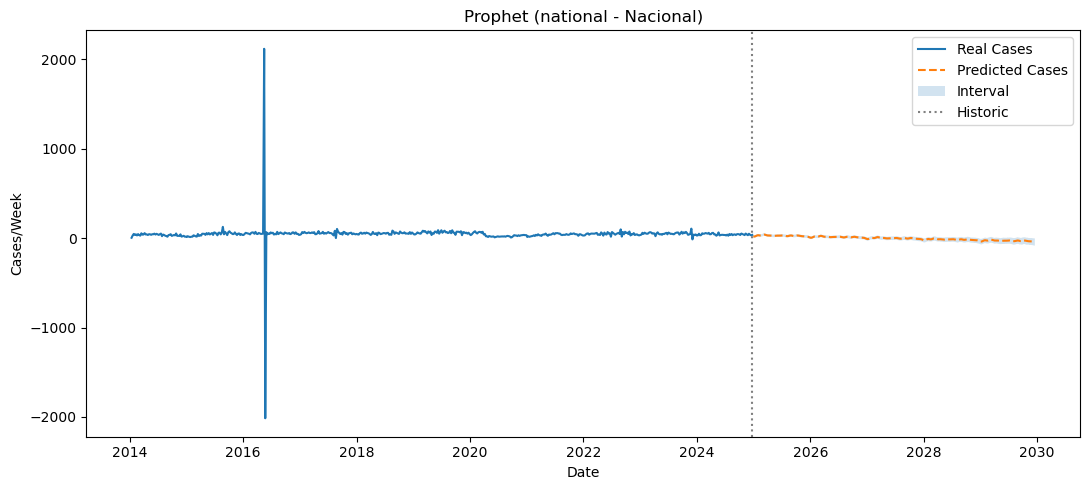

18:58:14 - cmdstanpy - INFO - Chain [1] start processing
18:58:14 - cmdstanpy - INFO - Chain [1] done processing
18:58:14 - cmdstanpy - INFO - Chain [1] done processing


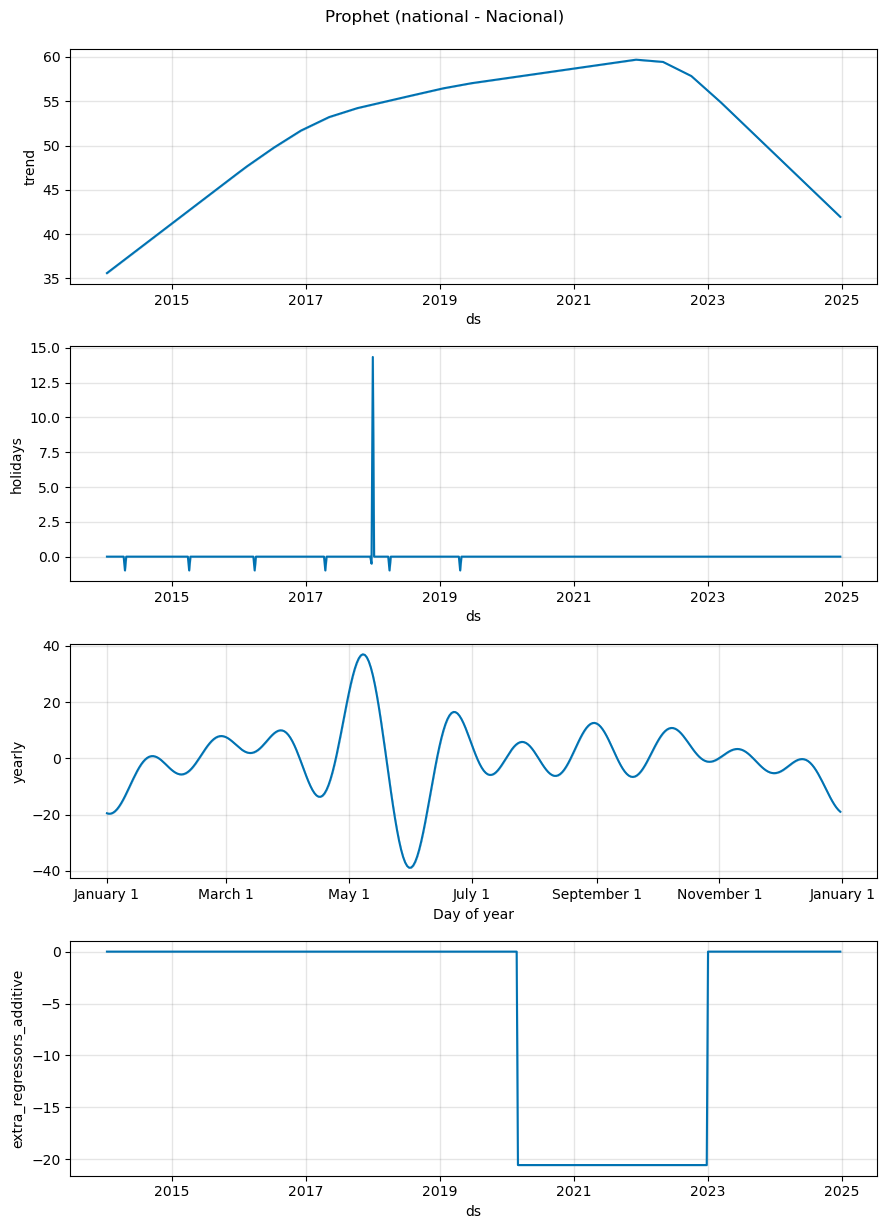

18:58:14 - cmdstanpy - INFO - Chain [1] start processing
18:58:14 - cmdstanpy - INFO - Chain [1] done processing
18:58:14 - cmdstanpy - INFO - Chain [1] done processing
18:58:17 - cmdstanpy - INFO - Chain [1] start processing
18:58:17 - cmdstanpy - INFO - Chain [1] start processing
18:58:17 - cmdstanpy - INFO - Chain [1] start processing
18:58:17 - cmdstanpy - INFO - Chain [1] start processing
18:58:17 - cmdstanpy - INFO - Chain [1] start processing
18:58:17 - cmdstanpy - INFO - Chain [1] start processing
18:58:17 - cmdstanpy - INFO - Chain [1] start processing
18:58:17 - cmdstanpy - INFO - Chain [1] start processing
18:58:17 - cmdstanpy - INFO - Chain [1] done processing
18:58:17 - cmdstanpy - INFO - Chain [1] done processing
18:58:17 - cmdstanpy - INFO - Chain [1] done processing
18:58:17 - cmdstanpy - INFO - Chain [1] done processing
18:58:17 - cmdstanpy - INFO - Chain [1] done processing
18:58:17 - cmdstanpy - INFO - Chain [1] done processing
18:58:17 - cmdstanpy - INFO - Chain [1]

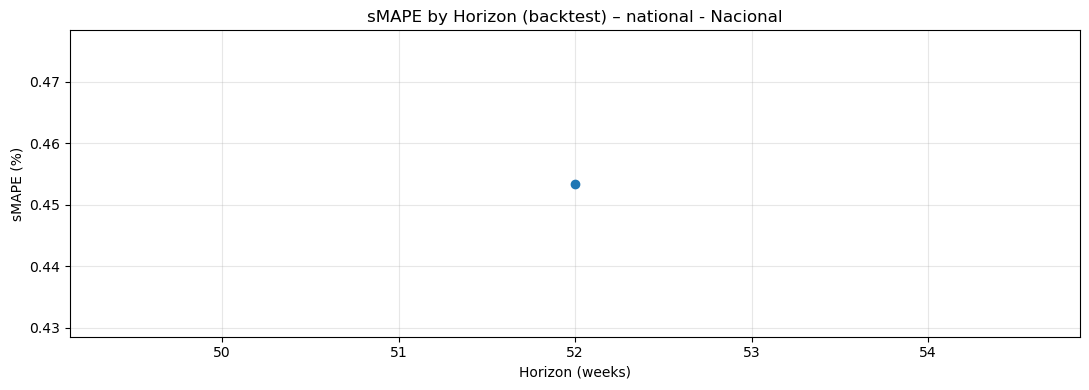

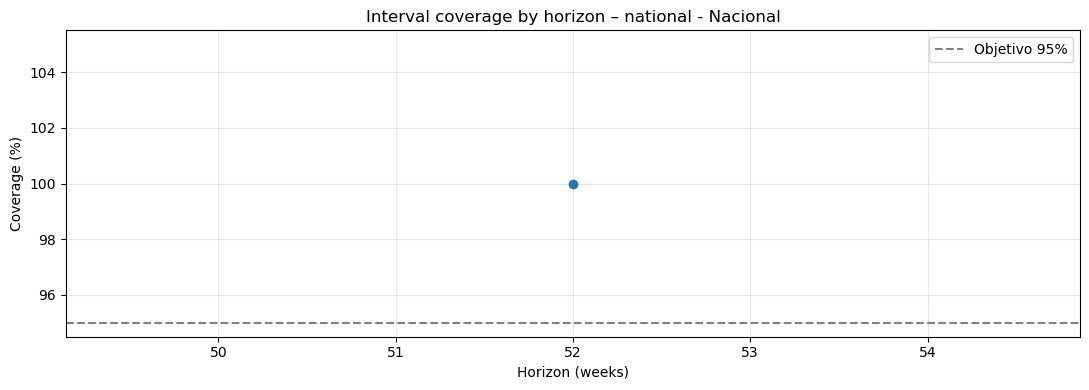

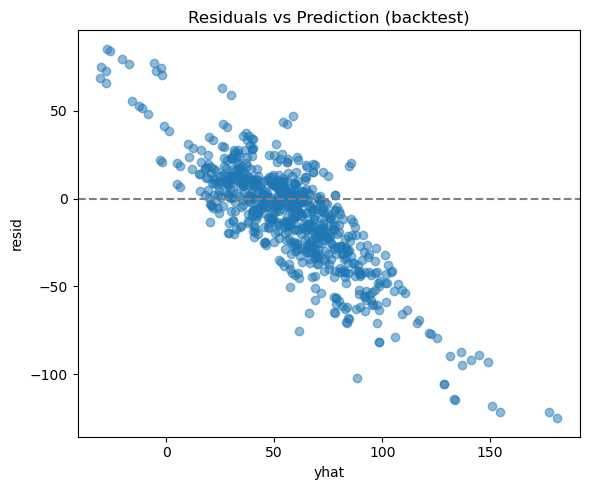

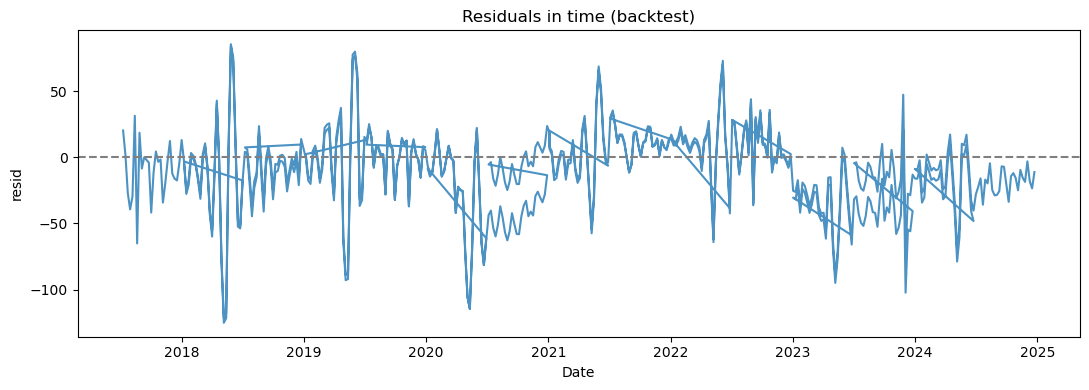

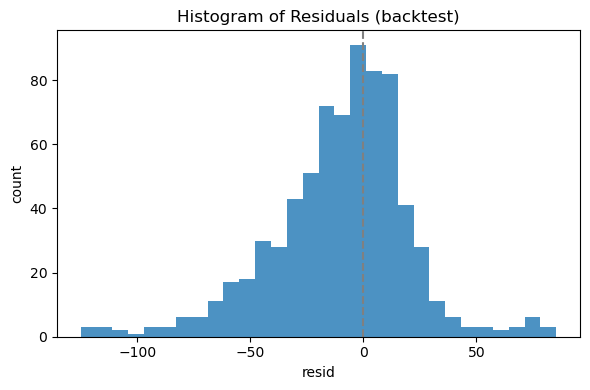

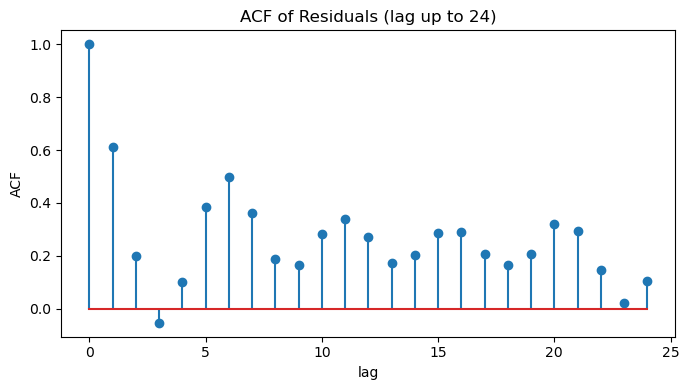

18:58:18 - cmdstanpy - INFO - Chain [1] start processing
18:58:18 - cmdstanpy - INFO - Chain [1] done processing
18:58:18 - cmdstanpy - INFO - Chain [1] done processing
18:58:20 - cmdstanpy - INFO - Chain [1] start processing
18:58:20 - cmdstanpy - INFO - Chain [1] start processing
18:58:20 - cmdstanpy - INFO - Chain [1] start processing
18:58:20 - cmdstanpy - INFO - Chain [1] done processing
18:58:20 - cmdstanpy - INFO - Chain [1] start processing
18:58:20 - cmdstanpy - INFO - Chain [1] start processing
18:58:20 - cmdstanpy - INFO - Chain [1] done processing
18:58:20 - cmdstanpy - INFO - Chain [1] start processing
18:58:20 - cmdstanpy - INFO - Chain [1] done processing
18:58:20 - cmdstanpy - INFO - Chain [1] done processing
18:58:20 - cmdstanpy - INFO - Chain [1] done processing
18:58:20 - cmdstanpy - INFO - Chain [1] done processing
18:58:20 - cmdstanpy - INFO - Chain [1] start processing
18:58:20 - cmdstanpy - INFO - Chain [1] start processing
18:58:20 - cmdstanpy - INFO - Chain [1]

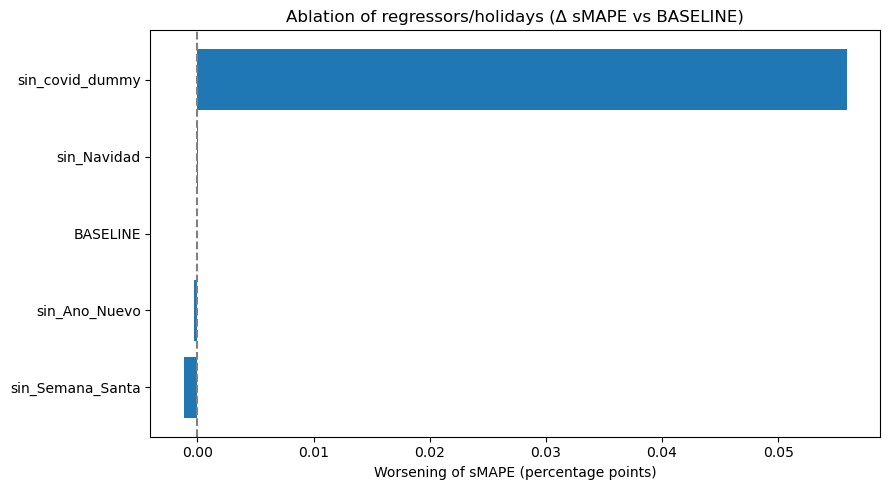

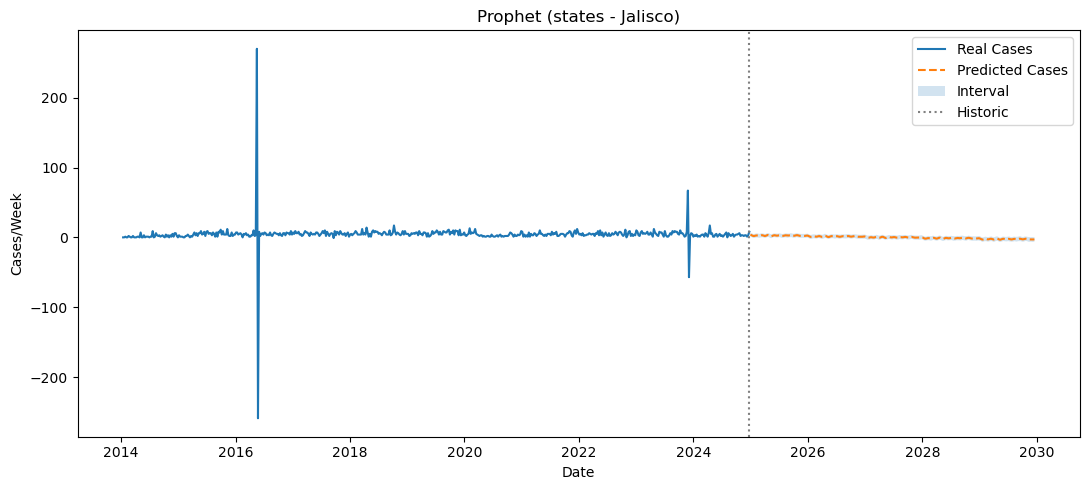

18:58:36 - cmdstanpy - INFO - Chain [1] start processing
18:58:37 - cmdstanpy - INFO - Chain [1] done processing
18:58:37 - cmdstanpy - INFO - Chain [1] done processing


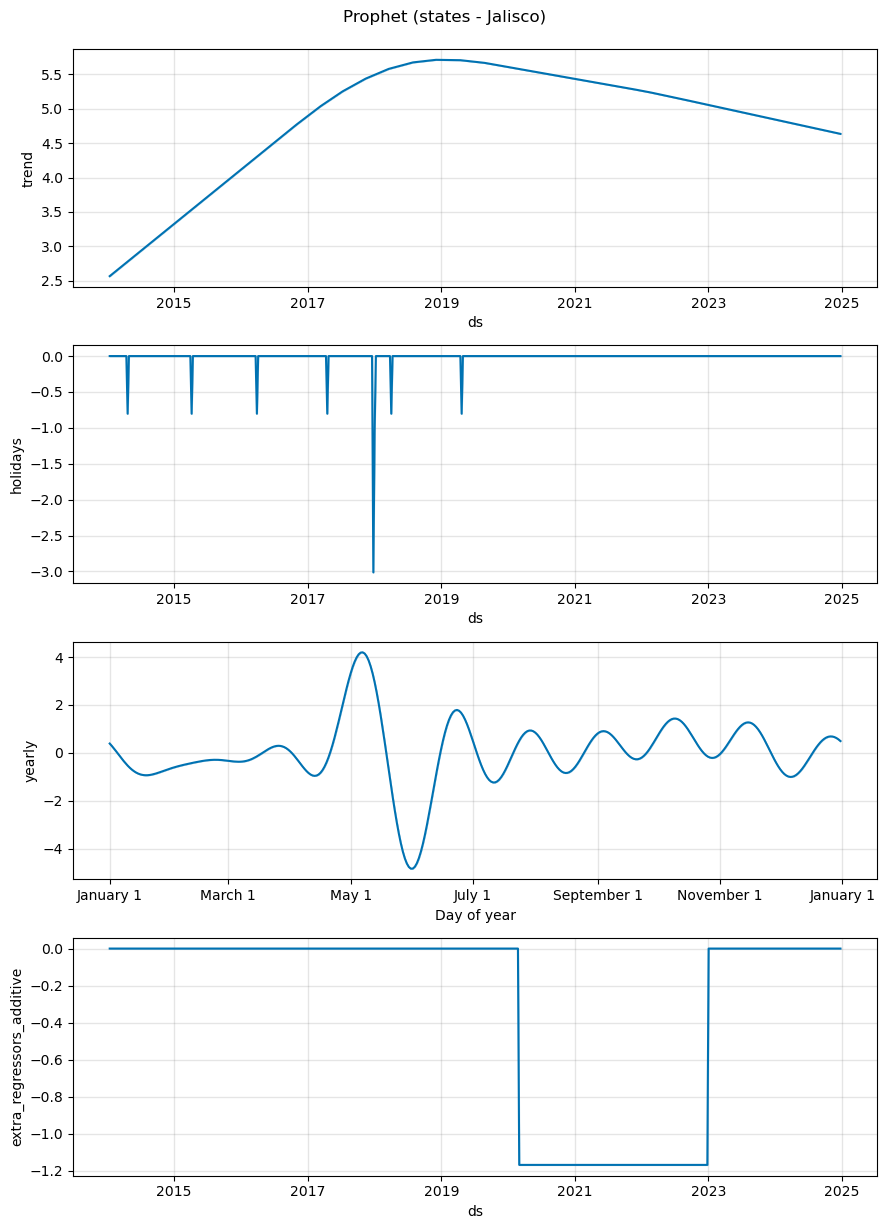

18:58:37 - cmdstanpy - INFO - Chain [1] start processing
18:58:37 - cmdstanpy - INFO - Chain [1] done processing
18:58:37 - cmdstanpy - INFO - Chain [1] done processing
18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing
18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing
18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing
18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing
18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing
18:58:39 - cmdstanpy - INFO - Chain [1]

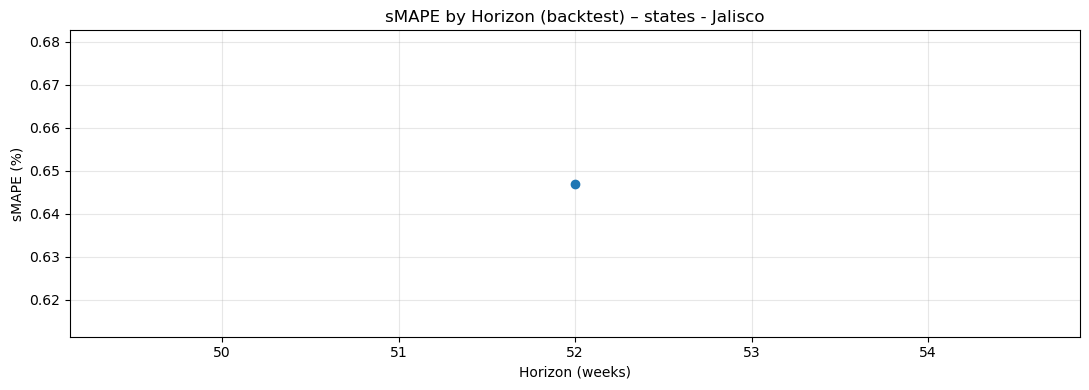

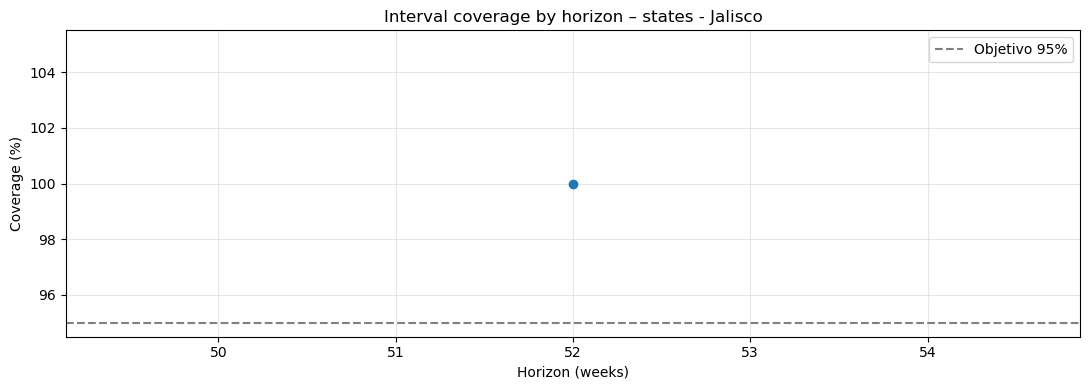

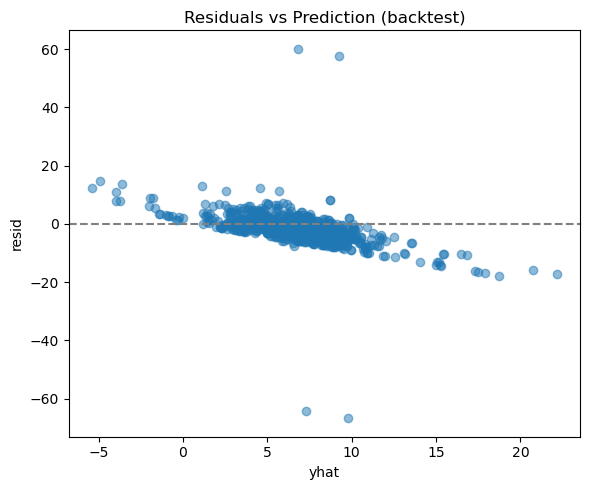

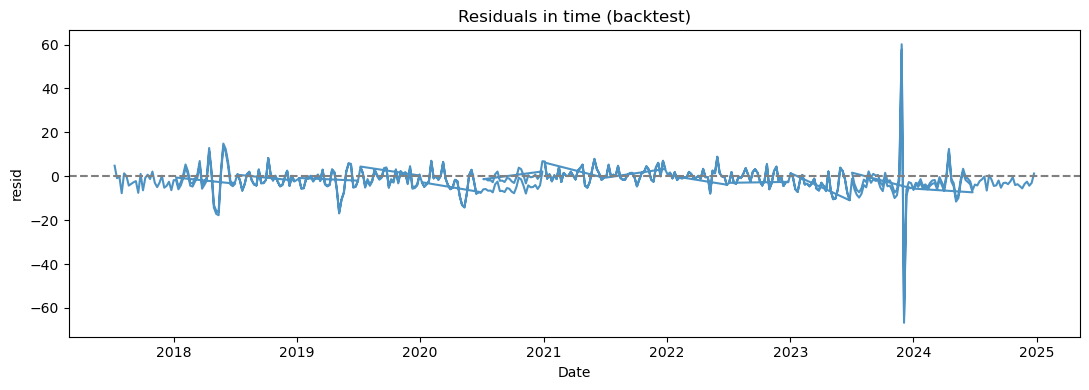

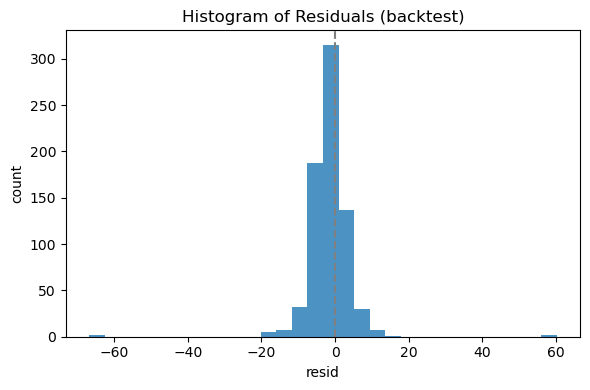

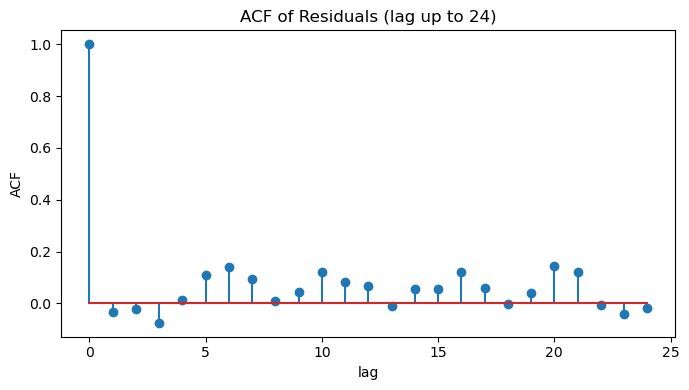

In [245]:
plot_forecast_future(res, df_national, dfs_states,dfs_states_sex, level="national")
plot_components_for_series(res, df_national, dfs_states,dfs_states_sex, holidays=res["holidays"])
cv_nat, perf_nat = backtest_plots(res, df_national, dfs_states, dfs_states_sex, holidays=res["holidays"])
residual_diagnostics(cv_nat)
ablation_importance(df_national, res["national"]["params"], res["holidays"])

choosen_state = "Jalisco"
plot_forecast_future(res, df_national, dfs_states,dfs_states_sex, level="states", geo=choosen_state)
plot_components_for_series(res, df_national, dfs_states, dfs_states_sex,holidays=res["holidays"], level="states", geo=choosen_state)
cv_st, perf_st = backtest_plots(res, df_national, dfs_states, dfs_states_sex, holidays=res["holidays"], level="states", geo=choosen_state)
residual_diagnostics(cv_st)

# plot_forecast_future(res, df_national, dfs_states,dfs_states_sex, level="states_sex", geo=choosen_state, sex="M")
# plot_components_for_series(res, df_national, dfs_states, dfs_states_sex,holidays=res["holidays"], level="states_sex", geo=choosen_state, sex="M")
# cv_ss, perf_ss = backtest_plots(res, df_national, dfs_states, dfs_states_sex,holidays=res["holidays"], level="states_sex", geo=choosen_state, sex="M")
# residual_diagnostics(cv_ss)